# Import packages & functions


In [1]:

print("importing modules")

# Standard Python libraries for data handling and system operations
import os
import sys
import json
import argparse
import numpy as np
import time
import random
import string
import h5py
from tqdm import tqdm  # Progress bars for long operations
import webdataset as wds  # WebDataset for efficient data loading
from PIL import Image  # Image processing
import pandas as pd  # Data manipulation
import nibabel as nib  # Neuroimaging data format (NIfTI)
import nilearn  # Neuroimaging analysis library

# Visualization libraries
import matplotlib.pyplot as plt

# Deep learning framework
import torch
import torch.nn as nn
from torchvision import transforms

# Enable TF32 for faster computation on modern GPUs (Ampere+)
# TF32 is a mixed precision format that's faster than float32 but maintains accuracy
torch.backends.cuda.matmul.allow_tf32 = True

# Custom utility functions for this project
import utils
from utils import load_preprocess_betas, resample, applyxfm, apply_thresh, resample_betas

# Import preprocessing utilities from a separate analysis pipeline
# This allows access to specialized fMRI preprocessing functions
import importlib.util
parent_utils_path = "/home/ri4541/mindeye_preproc/analysis/utils.py"
spec = importlib.util.spec_from_file_location("utils", parent_utils_path)
preproc = importlib.util.module_from_spec(spec)
parent_dir = os.path.dirname(parent_utils_path)
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
spec.loader.exec_module(preproc)

# Interactive notebook setup (only runs in Jupyter/IPython)
if utils.is_interactive():
    from IPython.display import clear_output  # Clear cell outputs
    get_ipython().run_line_magic('load_ext', 'autoreload')
    # Auto-reload allows automatic updates when utility functions are modified
    get_ipython().run_line_magic('autoreload', '2')
    
# Get seed for reproducible results (from SLURM job array or default)
seed = utils.get_slurm_seed()

importing modules
SLURM seed not found, using default: 0


# Princeton data prep
## Load Data & Design

In [2]:
# =============================================================================
# DATA LOADING AND PREPROCESSING CONFIGURATION
# =============================================================================
# This section sets up the experimental parameters and loads the fMRI data
# along with the corresponding visual stimuli design information.
# =============================================================================


def get_flag(name, default, cast=int):
    """
    Retrieve a flag from environment variables or return a default value.
    
    This function allows the script to be run both interactively (in Jupyter)
    and non-interactively (from command line or SLURM), automatically
    detecting the appropriate parameter values.
    
    Args:
        name: Name of the environment variable to check
        default: Default value if environment variable is not found
        cast: Type to cast the value to (int, str, bool, float)
    
    Returns:
        The retrieved or default value, cast to the specified type
    """
    if utils.is_interactive():
        return default
    val = os.environ.get(name.upper(), str(default))
    print(f"Retrieved {name.upper()} from environment: {val}")
    
    if cast == bool:
        # Explicitly handle string conversion to boolean
        if val.lower() in ['true', '1']:
            return True
        elif val.lower() in ['false', '0']:
            return False
        else:
            return bool(val)  # Fallback to default casting behavior
    
    try:
        return cast(val)
    except Exception:
        return val
    
# Check if running interactively or in batch mode
if not utils.is_interactive():
    print('running non-interactively')

In [3]:
# =============================================================================
# EXPERIMENTAL PARAMETERS
# =============================================================================
# These parameters control which subject, session, and task data to analyze
# They can be set via environment variables for batch processing
# =============================================================================

# Subject identifier (e.g., 'sub-005')
sub = get_flag('SUB', 'sub-005', cast=str)

# Session identifier (e.g., 'ses-04', 'all' for multiple sessions)
session = get_flag('SESSION', 'all', cast=str)

# Task identifier (e.g., 'study', 'A', or 'B')
task = get_flag('TASK', 'C', cast=str)

# Functional task name (usually same as task)
func_task_name = get_flag('FUNC_TASK_NAME', 'C', cast=str)

# Number of runs within specified sessions to trigger training
num_runs_to_train = get_flag('NUM_RUNS_TO_TRAIN', 5, cast=int)

# Handle multiple sessions if specified
if session == "all":
    ses_list = ["ses-01", "ses-03"]  # List of actual session IDs
    design_ses_list = ["ses-01", "ses-03"]  # Sessions to search for design matrix
else:
    ses_list = [session]
    design_ses_list = [session]

# Create task name string for file naming
task_name = f"_task-{task}" if task != 'study' else ''

In [4]:
# =============================================================================
# DATA RESAMPLING CONFIGURATION
# =============================================================================
# These parameters control whether and how to resample the fMRI data
# to different spatial resolutions
# =============================================================================

# Whether to resample voxel size (spatial resolution)
resample_voxel_size = get_flag('RESAMPLE_VOXEL_SIZE', False, cast=bool)

# Whether resampling happens after GLMSingle processing
resample_post_glmsingle = get_flag('RESAMPLE_POST_GLMSINGLE', False, cast=bool)

# Whether to load from pre-resampled files
load_from_resampled_file = get_flag('LOAD_FROM_RESAMPLED_FILE', False, cast=bool)

if resample_voxel_size:
    resampled_vox_size = get_flag('RESAMPLED_VOX_SIZE', 2.0, cast=float)  # Target voxel size in mm
    resample_method = get_flag('RESAMPLE_METHOD', 'trilinear', cast=str)  # Interpolation method
    
    # Create filename suffixes for resampled data
    vox_dim_str = str(resampled_vox_size).replace('.', '_')
    resampled_suffix = f"resampled_{vox_dim_str}mm_{resample_method}"
    mask_resampled_suffix = resampled_suffix
    
    if resample_post_glmsingle:
        resampled_suffix += '_postglmsingle'      
        
    print('resample_voxel_size:', resample_voxel_size)
    print('resample_post_glmsingle:', resample_post_glmsingle)
    print('load_from_resampled_file:', load_from_resampled_file)
    print('resampled_vox_size:', resampled_vox_size)
    print('resample_method:', resample_method)
    print('resampled_suffix:', resampled_suffix)
    print('mask_resampled_suffix:', mask_resampled_suffix)

In [5]:
# =============================================================================
# TRAINING/TESTING SPLIT CONFIGURATION
# =============================================================================
# These parameters control how the data is split for training and evaluation
# =============================================================================

# Training/testing split strategy:
# - 'MST': Multi-Session Test split (MST images for testing, others for training)
# - 'orig': Original split (repeated images for testing, others for training)
# - 'unique': Unique images for testing, repeated images for training
train_test_split = get_flag('TRAIN_TEST_SPLIT', 'cross', cast=str)

# Whether to remove images that are close to MST pairs
remove_close_to_MST = get_flag('REMOVE_CLOSE_TO_MST', False, cast=bool)

# Whether to randomly remove a subset of images
remove_random_n = get_flag('REMOVE_RANDOM_N', False, cast=bool)

# Ensure only one removal strategy is used
if remove_close_to_MST or remove_random_n:
    assert remove_close_to_MST != remove_random_n  # Don't remove both sets of images

# Number of images to remove if using random removal
n_to_remove = 0
if remove_random_n:
    # Random removal only makes sense with MST split since MST images are excluded
    assert train_test_split == 'MST'
    n_to_remove = 150  # Remove 150 images

In [6]:
# Print all configuration parameters for verification
print('sub:', sub)
print('session:', session)
print('task:', task)
print('func_task_name:', func_task_name)
print('ses_list:', ses_list)
print('design_ses_list:', design_ses_list)
print('task_name:', task_name)
print('train_test_split:', train_test_split)
print('remove_close_to_MST:', remove_close_to_MST)
print('remove_random_n:', remove_random_n)
print('n_to_remove:', n_to_remove)


sub: sub-005
session: all
task: C
func_task_name: C
ses_list: ['ses-01', 'ses-03']
design_ses_list: ['ses-01', 'ses-03']
task_name: _task-C
train_test_split: cross
remove_close_to_MST: False
remove_random_n: False
n_to_remove: 0


In [7]:
# =============================================================================
# SESSION AND RUN INFORMATION
# =============================================================================
# Get session labels and run counts for the specified sessions
# =============================================================================

# Get a combined session label for file naming
session_label = preproc.get_session_label(ses_list)
print('session label:', session_label)

# Get the number of runs per session for this subject
n_runs, _ = preproc.get_runs_per_session(sub, session, ses_list)


session label: ses-01+03


In [13]:
# =============================================================================
# GLMSINGLE PATH CONFIGURATION
# =============================================================================
# GLMSingle is a tool that performs single-trial fMRI analysis
# This section sets up the paths to the processed GLMSingle outputs
# =============================================================================

# Set the path to GLMSingle outputs based on whether running interactively or not
if utils.is_interactive():
    glmsingle_paths = [f"/scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2/glmsingle_{sub}_{s}_task-{task}" for s in ses_list]
    if len(glmsingle_paths) == 1:
        glmsingle_path == glmsingle_paths[0] # handeling single session case
else:
    glmsingle_path = os.environ["glmsingle_path"]
    
# Path to design files (stimulus timing and image information)
designdir = "/home/ri4541/real_time_mindEye2"
print(glmsingle_paths)

for glmsingle_path in glmsingle_paths:
    # Verify the GLMSingle path exists
    assert os.path.exists(glmsingle_path)
    print(f"glmsingle path exists for {glmsingle_path}!")

# Handle resampling paths based on configuration
if resample_voxel_size:
    # Two options for resampling:
    # Option 1: Use original GLMSingle outputs and do resampling here
    # Option 2: Use pre-resampled GLMSingle outputs (no resampling needed here)
    
    if resample_post_glmsingle:
        # Option 1: We are using original GLMSingle outputs and doing resampling here
        orig_glmsingle_path = glmsingle_path
        glmsingle_path += f"_{resampled_suffix}"
        print("resampled glmsingle path:", glmsingle_path)
        
        if load_from_resampled_file:
            # Resampling is already done; load from file
            assert os.path.exists(glmsingle_path)  # The new directory must exist
        else:
            # Don't load from file; do resampling here
            os.makedirs(glmsingle_path, exist_ok=True)
    else:
        # Option 2: Resampling was done pre-GLMSingle
        glmsingle_path += f"_{resampled_suffix}"
        print("glmsingle path:", glmsingle_path)



['/scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2/glmsingle_sub-005_ses-01_task-C', '/scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2/glmsingle_sub-005_ses-03_task-C']
glmsingle path exists for /scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2/glmsingle_sub-005_ses-01_task-C!
glmsingle path exists for /scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2/glmsingle_sub-005_ses-03_task-C!


In [15]:
# =============================================================================
# LOAD DESIGN FILES AND STIMULUS INFORMATION
# =============================================================================
# This section loads the experimental design information including:
# - Stimulus timing (when each image was shown)
# - Image names and file paths
# - Run boundaries (when new fMRI runs start)
# - Unique image identifiers
# =============================================================================

# Load design files which contain stimulus timing and image information
# Returns:
# - data: DataFrame with experimental design information
# - starts: Array indicating start times for each stimulus
# - images: Array of image names/paths
# - is_new_run: Boolean array indicating start of new fMRI runs
# - image_names: Array of image names for each trial
# - unique_images: Array of unique image names (no duplicates)
# - len_unique_images: Number of unique images
data, starts, images, is_new_run, image_names, unique_images, len_unique_images = preproc.load_design_files(
    sub=sub,
    session=session,
    func_task_name=task,
    designdir=designdir,
    design_ses_list=design_ses_list
)

# =============================================================================
# VALIDATE DESIGN FILE LOADING
# =============================================================================
# These assertions verify that the correct data was loaded for each subject/session
# This helps catch data loading errors early
# =============================================================================

# Verify correct image loading for different subjects and sessions
if sub == 'sub-001':
    if session == 'ses-01':
        assert image_names[0] == 'images/image_686_seed_1.png'
    elif session in ('ses-02', 'all'):
        assert image_names[0] == 'all_stimuli/special515/special_40840.jpg'
    elif session == 'ses-03':
        assert image_names[0] == 'all_stimuli/special515/special_69839.jpg'
    elif session == 'ses-04':
        assert image_names[0] == 'all_stimuli/rtmindeye_stimuli/image_686_seed_1.png'
elif sub == 'sub-003':
    assert image_names[0] == 'all_stimuli/rtmindeye_stimuli/image_686_seed_1.png'

# Get unique images and remove any NaN values
unique_images = np.unique(image_names.astype(str))
unique_images = unique_images[(unique_images!="nan")]
len_unique_images = len(unique_images)
print("n_runs", n_runs)

# Verify expected number of unique images for specific subject/session combinations
if (sub == 'sub-001' and session == 'ses-04') or (sub == 'sub-003' and session == 'ses-01'):
    assert len(unique_images) == 851

# Print sample data for verification
print(image_names[:4])
print(starts[:4])
print(is_new_run[:4])

Loading: /home/ri4541/real_time_mindEye2/csv/sub-005_ses-01.csv
Loading: /home/ri4541/real_time_mindEye2/csv/sub-005_ses-03.csv
Using design file: /home/ri4541/real_time_mindEye2/csv/sub-005_ses-03.csv
Total number of images: 1540
Number of unique images: 1001
n_runs 22
['all_stimuli/special515/special_15939.jpg'
 'all_stimuli/special515/special_23241.jpg'
 'all_stimuli/special515/special_32232.jpg'
 'all_stimuli/special515/special_34238.jpg']
[190.2773371 194.2907918 198.3011098 202.3095724]
[0. 0. 0. 0.]


In [18]:
# =============================================================================
# IMAGE REMOVAL LOGIC
# =============================================================================
# This section handles removing specific images based on experimental design
# - remove_random_n: Randomly removes a subset of images for ablation studies
# - remove_close_to_MST: Removes images that are too similar to MST test pairs
# =============================================================================

if remove_random_n:
    # Want to remove 150 images total
    # 100 special515 images are repeated 3x (300 total presentations)
    # All other training images are only shown once (558 total presentations)
    # Of the 150 to remove, sample proportionally:
    # - 51 from special515 (17 unique images, removing all 3 repeats)
    # - 99 from the rest (99 unique images)
    
    np.random.seed(seed)  # Ensure reproducible random selection
    
    # Find images that only appear once (non-special515, non-MST)
    options_to_remove = [x for x in set(image_names) 
                        if str(x) != 'nan' and x != 'blank.jpg' 
                        and 'MST_pairs' not in x and 'special515' not in x 
                        and list(image_names).count(x)==1]
    
    # Find special515 images that are repeated
    options_to_remove_special515 = [x for x in set(image_names) 
                                   if str(x) != 'nan' and x != 'blank.jpg' 
                                   and 'MST_pairs' not in x and 'special515' in x 
                                   and list(image_names).count(x)>1]
    
    # Randomly select images to remove
    imgs_to_remove = np.random.choice(options_to_remove, size=99, replace=False)
    imgs_to_remove = np.append(imgs_to_remove, 
                              np.random.choice(options_to_remove_special515, size=17, replace=False))

In [29]:
# =============================================================================
# IMAGE INDEXING AND MST IDENTIFICATION
# =============================================================================
# This section processes the image names to create indices and identify
# MST images that will be used for evaluation
# =============================================================================

# Initialize arrays to store image indices and names
image_idx = np.array([])  # Contains the unique index of each presented image
vox_image_names = np.array([])  # Contains the names of the images corresponding to image_idx
all_MST_images = dict()  # Dictionary to store MST image information

# Process each image name to create indices and identify MST images
for i, im in enumerate(image_names):
    # Skip blank images and NaN values
    if im == "blank.jpg":
        i += 1
        continue
    if str(im) == "nan":
        i += 1
        continue
    
    # Store the image name
    vox_image_names = np.append(vox_image_names, im)
    
    # Handle image removal based on configuration
    if remove_close_to_MST:  # Optionally skip close_to_MST images 
        if "closest_pairs" in im:
            i += 1
            continue
    elif remove_random_n:
        if im in imgs_to_remove:
            i += 1
            continue
            
    # Get the index of this image in the unique_images array
    image_idx_ = np.where(im == unique_images)[0].item()
    image_idx = np.append(image_idx, image_idx_)
    
    # Identify MST images based on subject and session
    # MST images are special pairs used for cross-session evaluation
    if (sub == 'sub-001' and session == 'ses-04') or (sub == 'sub-003' and session == 'ses-01'):
        import re
        # Look for specific patterns that indicate MST images:
        # - 'w_' prefix
        # - 'paired_image_' prefix  
        # - Pattern: all_stimuli/rtmindeye_stimuli/XX_XXX.png (1-2 digits, underscore, 1-3 digits)
        # - Pattern: images/XX_XXX.png (1-2 digits, underscore, 1-3 digits)
        if ('w_' in im or 'paired_image_' in im or 
            re.match(r'all_stimuli/rtmindeye_stimuli/\d{1,2}_\d{1,3}\.png$', im) or 
            re.match(r'images/\d{1,2}_\d{1,3}\.png$', im)):
            all_MST_images[i] = im
            i += 1            
    elif 'MST' in im:  # For other subjects, look for 'MST' in filename
        all_MST_images[i] = im
        i += 1

# Convert image indices to PyTorch tensor
image_idx = torch.Tensor(image_idx).long()

# Get unique MST images (remove duplicates)
unique_MST_images = np.unique(list(all_MST_images.values())) 

In [32]:
# =============================================================================
# MST ID ARRAY CREATION
# =============================================================================
# Create an array that maps each image to its MST pair ID
# This is used later for evaluation and analysis
# =============================================================================

# Initialize MST_ID array
MST_ID = np.array([], dtype=int)

# Initialize arrays for tracking removed images if needed
if remove_close_to_MST:
    close_to_MST_idx = np.array([], dtype=int)
if remove_random_n:
    random_n_idx = np.array([], dtype=int)

# Create voxel index array for tracking removed images
vox_idx = np.array([], dtype=int)
j = 0  # Counter for tracking removed images (used later for indexing)

# Process each image to create MST_ID mapping
for i, im in enumerate(image_names):
    # Skip blank images and NaN values
    if im == "blank.jpg":
        i += 1
        continue
    if str(im) == "nan":
        i += 1
        continue
    
    # Handle image removal and track indices
    if remove_close_to_MST:  # Optionally skip close_to_MST images 
        if "closest_pairs" in im:
            close_to_MST_idx = np.append(close_to_MST_idx, i)
            i += 1
            continue
    if remove_random_n:
        if im in imgs_to_remove:
            vox_idx = np.append(vox_idx, j)
            i += 1
            j += 1
            continue
    j += 1
    
    # Find the MST pair ID for this image
    curr = np.where(im == unique_MST_images)
    if curr[0].size == 0:
        # Image is not an MST image, assign out-of-range ID
        MST_ID = np.append(MST_ID, np.array(len(unique_MST_images)))
    else:
        # Image is an MST image, assign its pair ID
        MST_ID = np.append(MST_ID, curr)
        
# Verify that MST_ID array has the same length as image_idx
assert len(MST_ID) == len(image_idx)

# Print MST information for verification
print(MST_ID.shape)

# Verify expected number of MST images for specific subject/session combinations
if (sub == 'sub-001' and session == 'ses-04') or (sub == 'sub-003' and session == 'ses-01'):
    assert len(all_MST_images) == 100


(1386,)


## Load images

In [35]:
# =============================================================================
# LOAD AND PREPROCESS VISUAL STIMULI IMAGES
# =============================================================================
# This section loads the actual image files that were shown to participants
# during the fMRI experiment and prepares them for the neural network
# =============================================================================

# Import image processing libraries
import imageio.v2 as imageio

# Create image transformation pipeline
# Resize all images to 224x224 pixels (standard size for many vision models)
resize_transform = transforms.Resize((224, 224))

# Initialize arrays to store images and MST information
MST_images = []
images = None

# Load each image based on the image indices
for im_name in tqdm(image_idx):
    # Construct file path based on subject and session
    if sub == 'sub-001' and session == 'ses-01':
        image_file = f"all_stimuli/rtmindeye_stimuli/{unique_images[im_name]}"
    else:
        image_file = f"{unique_images[im_name]}"
    
    # Load image using imageio
    im = imageio.imread(image_file)
    
    # Convert to PyTorch tensor and normalize to [0,1] range
    im = torch.Tensor(im / 255).permute(2, 0, 1)  # Convert to channels-first format (C, H, W)
    
    # Resize image to 224x224
    im = resize_transform(im.unsqueeze(0))  # Add batch dimension
    
    # Stack images vertically to create a batch
    if images is None:
        images = im
    else:
        images = torch.vstack((images, im))
    
    # Identify MST images for evaluation
    if (sub == 'sub-001' and session == 'ses-04') or (sub == 'sub-003' and session == 'ses-01'):
        # Look for specific patterns that indicate MST images
        if ('w_' in image_file or 'paired_image_' in image_file or 
            re.match(r'all_stimuli/rtmindeye_stimuli/\d{1,2}_\d{1,3}\.png$', image_file) or 
            re.match(r'all_stimuli/rtmindeye_stimuli/images/\d{1,2}_\d{1,3}\.png$', image_file)):
            MST_images.append(True)
        else:
            MST_images.append(False)
    else:   
        # For other subjects, look for 'MST_pairs' in filename
        if ("MST_pairs" in image_file):
            MST_images.append(True)
        else:
            MST_images.append(False)

# Print image information for verification
print("images", images.shape)
MST_images = np.array(MST_images)
print("MST_images", len(MST_images))

# Verify expected number of MST images for specific subject/session combinations
if (sub == 'sub-001' and session == 'ses-04') or (sub == 'sub-003' and session == 'ses-01'):
    assert len(MST_images[MST_images==True]) == 100

print("MST_images==True", len(MST_images[MST_images==True]))

  0%|          | 0/1386 [00:00<?, ?it/s]/home/wg7536/.conda/envs/rt_mindEye2/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 1386/1386 [02:12<00:00, 10.43it/s]

images torch.Size([1386, 3, 224, 224])
MST_images 1386
MST_images==True 248


In [37]:
# =============================================================================
# MST PAIRMATE IDENTIFICATION
# =============================================================================
# This section identifies which images form MST pairs for evaluation
# MST pairs are images that are shown in multiple sessions to test
# cross-session generalization of the brain decoding model
# =============================================================================

# Verify that we have an even number of MST images (they should come in pairs)
assert unique_MST_images.shape[0] % 2 == 0

# Reshape unique MST images into pairs (N/2 rows, 2 columns)
# Each row contains two images that form a pair
MST_pairmate_names = unique_MST_images.reshape(int(unique_MST_images.shape[0]/2), 2)

# Create array to store the indices of MST pairmates
MST_pairmate_indices = np.empty(shape=MST_pairmate_names.shape, dtype=int)

# For each MST pair, find the indices in the all_MST_images dictionary
for p, pair in enumerate(MST_pairmate_names):
    for i, im in enumerate(pair):
        # Find the index of this image in the all_MST_images values
        # Take the first repeated instance if an image appears multiple times
        MST_pairmate_indices[p][i] = np.where(np.isin(list(all_MST_images.values()), im))[0][0]
        
print(MST_pairmate_indices.shape, MST_pairmate_indices)


(31, 2) [[110  25]
 [ 15   6]
 [ 18  43]
 [ 95  49]
 [ 14  70]
 [ 12  20]
 [ 51  63]
 [ 87  50]
 [  2  58]
 [ 45   8]
 [ 27  39]
 [ 92  19]
 [ 55  33]
 [ 78  26]
 [  0  65]
 [ 32  28]
 [ 23  72]
 [ 54  91]
 [ 11  21]
 [ 76  13]
 [  5  34]
 [ 53  52]
 [ 66  40]
 [ 22  69]
 [107  24]
 [  7 106]
 [ 42   3]
 [ 44  10]
 [ 30   4]
 [ 86  60]
 [ 16  59]]


In [38]:
# =============================================================================
# MST PAIRS VISUALIZATION AND VALIDATION
# =============================================================================
# This section visualizes MST pairs to verify they are correctly identified
# and shows how the same image appears across different sessions
# =============================================================================

if (sub == 'sub-001' and session in ('ses-02', 'ses-03', 'all')):
    # Find paired indices based on MST_ID array
    # MST_pairs contains the indices of repeats based on all_MST_images
    MST_pairs = utils.find_paired_indices(torch.tensor(MST_ID))
    
    # Sort pairs and remove the last group (which was added as a placeholder)
    MST_pairs = np.array(sorted(MST_pairs[:-1], key=lambda x: x[0]))

    # Create visualization of sample MST pairs
    fig, ax = plt.subplots(1, 3, figsize=(10, 4))
    fig.suptitle('Sample MST pairs')

    # Display the first image in the pair
    ax[0].imshow(images[MST_pairs[-1][0]].permute(1, 2, 0).numpy())
    ax[0].set_title(f"Trial 0")

    # Display the second image in the pair
    ax[1].imshow(images[MST_pairs[-1][1]].permute(1, 2, 0).numpy())
    ax[1].set_title(f"Trial 1")

    # Display the third image in the pair (if it exists)
    ax[2].imshow(images[MST_pairs[-1][2]].permute(1, 2, 0).numpy())
    ax[2].set_title(f"Trial 2")

    # Remove axis ticks for cleaner visualization
    plt.setp(ax, xticks=[], yticks=[])
    plt.tight_layout()
    plt.show()

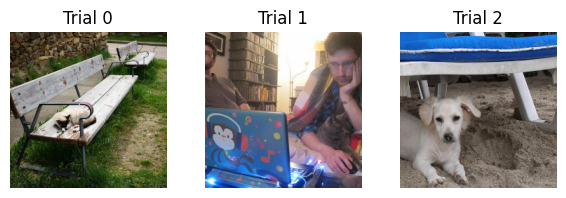

In [39]:
# =============================================================================
# GENERAL IMAGE PAIRS IDENTIFICATION AND VISUALIZATION
# =============================================================================
# This section identifies all repeated images (not just MST pairs) and
# visualizes them to show the structure of the experimental design
# =============================================================================

# Find all pairs of repeated images using the image_idx array
# pairs has the indices of all repeated images across sessions
pairs = utils.find_paired_indices(image_idx)
pairs = sorted(pairs, key=lambda x: x[0])

# Create visualization of the first few image pairs
fig, axes = plt.subplots(1, 3, figsize=(6, 2))  # 1 row, 3 columns
for i, ax in enumerate(axes):
    ax.imshow(images[i].permute(1, 2, 0).numpy())
    ax.set_title(f"Trial {i}")
    ax.axis("off")  # Hide axes for better visualization

plt.tight_layout()
# output_path = os.path.join(output_dir, "trials_plot.png")
# plt.savefig(output_path, dpi=300)  # Save figure
plt.show()


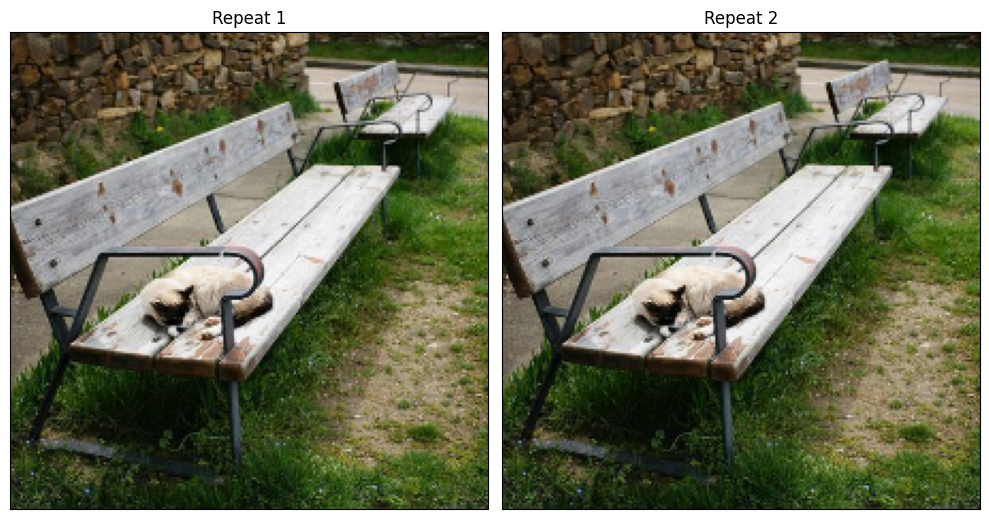

In [40]:
# =============================================================================
# SAMPLE PAIR VISUALIZATION
# =============================================================================
# Display a specific pair of repeated images to show the quality
# of the experimental design and image presentation
# =============================================================================

p = 0  # Index of the pair to visualize

# Plot 2 repeats (anything in pairs should have 2 repeats, even if there's more)
fig, ax = plt.subplots(1, 2, figsize=(10, 8))

# Display the first repeat of the image
ax[0].imshow(images[pairs[p][0]].permute(1, 2, 0).numpy())
ax[0].set_title(f"Repeat 1")

# Display the second repeat of the image
ax[1].imshow(images[pairs[p][1]].permute(1, 2, 0).numpy())
ax[1].set_title(f"Repeat 2")

# Remove axis ticks for cleaner visualization
plt.setp(ax, xticks=[], yticks=[])
plt.tight_layout()
plt.show()


In [41]:
# =============================================================================
# IMAGE PAIRS UTILITY FUNCTION
# =============================================================================
# This function provides a convenient way to load design files and process
# image pairs for a given session, used later for creating training/testing splits
# =============================================================================

def get_image_pairs(sub, session, func_task_name, designdir):
    """
    Loads design files and processes image pairs for a given session.
    
    This function is a wrapper around the preprocessing utilities that:
    1. Loads the design files for a specific subject/session
    2. Processes the image names to identify pairs
    3. Returns the processed image and voxel information
    
    Args:
        sub: Subject identifier
        session: Session identifier
        func_task_name: Functional task name
        designdir: Directory containing design files
    
    Returns:
        Tuple of (image_pairs, voxel_pairs, additional_info)
    """
    _, _, _, _, image_names, unique_images, _ = preproc.load_design_files(
        sub=sub,
        session=session,
        func_task_name=func_task_name,
        designdir=designdir,
        design_ses_list=[session]  # Ensure it's a list
    )
    return utils.process_images(image_names, unique_images)


In [42]:
# =============================================================================
# IMAGE-TO-INDICES MAPPING ACROSS SESSIONS
# =============================================================================
# This section creates a mapping from image names to their indices across
# different sessions, which is essential for multi-session training and
# the MST (Multi-Session Test) evaluation strategy
# =============================================================================

from collections import defaultdict

# Initialize list to store dictionaries mapping indices to image names for each session
all_dicts = []

# Process each session to create index-to-name mappings
for s_idx, s in enumerate(ses_list):
    # Get image pairs for this session
    im, vo, _ = get_image_pairs(sub, s, func_task_name, designdir)
    assert len(im) == len(vo)
    
    # Create dictionary mapping indices to image names
    all_dicts.append({k: v for k, v in enumerate(vo)})

Data shape: (780, 122)
Using design file: /home/ri4541/real_time_mindEye2/csv/sub-005_ses-01.csv
Total number of images: 770
Number of unique images: 532
Data shape: (780, 126)
Using design file: /home/ri4541/real_time_mindEye2/csv/sub-005_ses-03.csv
Total number of images: 770
Number of unique images: 532


In [43]:
# =============================================================================
# CREATE IMAGE-TO-INDICES MAPPING FOR TRAINING SET
# =============================================================================
# For the training set (ses-01-02 non-MST), create a mapping that shows
# which images appear in which sessions and at what indices
# =============================================================================

# Create defaultdict that maps image names to lists of indices for each session
# Each image name maps to a list where each element contains the indices for that session
image_to_indices = defaultdict(lambda: [[] for _ in range(len(ses_list))])

# Populate the mapping for each session
for ses_idx, idx_to_name in enumerate(all_dicts):
    for idx, name in idx_to_name.items():
        image_to_indices[name][ses_idx].append(idx)
        
# Convert defaultdict to regular dict
image_to_indices = dict(image_to_indices)

# Note: Test set mapping (ses-03) is commented out but could be implemented similarly
# for the test set (ses-03)
# test_image_to_indices = defaultdict(lambda: [[] for _ in range(len([ses_list[-1]]))])
# for ses_idx, idx_to_name in enumerate([all_dicts[-1]]):
#     for idx, name in idx_to_name.items():
#         test_image_to_indices[name][ses_idx].append(idx)
        
# test_image_to_indices = dict(test_image_to_indices)

In [49]:
# =============================================================================
# SESSION-SPECIFIC INDEX ADJUSTMENTS
# =============================================================================
# This section handles special cases where indices need to be adjusted
# for specific subject/session combinations to ensure proper alignment
# across sessions
# =============================================================================

# Special handling for sub-005 with ses-01 and ses-02
if sub == 'sub-005' and ses_list == ["ses-01", "ses-02"]:
    # For this specific subject/session combination, we need to offset
    # session 1 indices by 693 to align them with session 0 indices
    # This ensures proper indexing when combining data across sessions
    
    for image, (ses0_indices, ses1_indices) in image_to_indices.items():
        # Offset session 1 indices by 693 to align with session 0
        image_to_indices[image] = [ses0_indices, [i + 693 for i in ses1_indices]]

    # Note: The commented code below shows how pairs could be created
    # by combining indices across sessions, but it's not currently used
    #         # Combine all repeat indices (across both sessions)
    #         all_indices = ses0_indices + ses1_indices_offset
    # 
    #         # Only include if there are at least 2 repeats
    #         if len(all_indices) >= 2:
    #             train_pairs_list.append(all_indices)
        
    #     for i in test_image_to_indices.values():
    #         # print(i[0])
    #         # Only include if there are at least 2 repeats
    #         if len(i[0]) >= 2:
    #             test_pairs_list.append(i[0])
            
    #     train_test_pairs = [train_pairs_list, test_pairs_list]
            
# elif sub == 'sub-005' and ses_list == ["ses-01", "ses-03"]:
#     # Alternative handling for different session combinations
#     pairs_list = []
# 
#     if len(ses_list) > 2:
#         # Case 1: Aggregate results from multiple sessions (ses_list[:-1]), concatenating into a single list
#         combined_pairs = sum([get_image_pairs(sub, s, func_task_name, designdir) for s in ses_list[:-1]], [])
#         pairs_list.append(combined_pairs)
# 
#         # Case 2: Process last session separately
#         pairs_list.append(get_image_pairs(sub, ses_list[-1], func_task_name, designdir))
# 
#     else:
#         # Case 3: Process both sessions individually if ses_list has only 2 entries
#         pairs_list.extend([get_image_pairs(sub, s, func_task_name, designdir) for s in ses_list])
# 
#     assert len(pairs_list) == 2

In [51]:
# =============================================================================
# RESAMPLING SETUP FOR FMRI DATA
# =============================================================================
# This section sets up the necessary files and paths for resampling
# fMRI data to different spatial resolutions if needed
# =============================================================================

if resample_voxel_size:
    # Import Nilearn functions for masking and spatial transformations
    from nilearn.masking import apply_mask, unmask
    
    # Reference image for resampling (target space)
    ref_name = f'{glmsingle_path}/boldref_resampled.nii.gz'
    
    # Transformation matrix file (contains the spatial transformation parameters)
    omat_name = f'{glmsingle_path}/boldref_omat'

In [53]:
# =============================================================================
# BRAIN MASK LOADING AND PROCESSING
# =============================================================================
# This section loads the whole brain mask that defines which voxels (3D pixels)
# should be included in the analysis
# =============================================================================

from nilearn.plotting import plot_roi, plot_anat, plot_epi

# Construct the mask filename based on configuration
mask_name = f'{glmsingle_path}/{sub}_{session_label}{task_name}_brain'

if resample_voxel_size:
    if resample_post_glmsingle is True:
        # Use original mask directory if resampling happens after GLMSingle
        mask_in_name = f'{orig_glmsingle_path}/{sub}_{session}{task_name}_brain.nii.gz'
        mask_out_name = mask_name + f"_{mask_resampled_suffix}.nii.gz"
        
        # Verify the input mask exists
        assert os.path.exists(mask_in_name)
        
        # Apply spatial transformation to the mask
        applyxfm(mask_in_name, ref_name, omat_name, resample_method, output=mask_out_name)
        
        # Binarize the mask since resampling can result in non-binary values
        apply_thresh(mask_out_name, 0.5, output=mask_out_name)
    
    # Add resampling suffix to mask name
    mask_name += f"_{mask_resampled_suffix}"

# Add file extension
mask_name += ".nii.gz"
print(mask_name)

# Load the brain mask using Nibabel
avg_mask = nib.load(mask_name)

/scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2/glmsingle_sub-005_ses-01_task-C/sub-005_ses-01_task-C_brain.nii.gz


In [54]:
# =============================================================================
# MASK INFORMATION EXTRACTION
# =============================================================================
# Extract key information about the brain mask including dimensions,
# spatial transformation matrix, and number of included voxels
# =============================================================================

# Get mask dimensions and spatial information
dimsize = avg_mask.header.get_zooms()  # Voxel dimensions in mm
affine_mat = avg_mask.affine  # Spatial transformation matrix
brain = avg_mask.get_fdata()  # Actual mask data as numpy array
xyz = brain.shape  # 3D dimensions of brain mask and EPI data

# Print mask information
print('Mask dimensions:', dimsize)
print('')
print('Affine:')
print(affine_mat)
print('')
print(f'There are {int(np.sum(brain))} voxels in the included brain mask\n')


Mask dimensions: (2.0, 2.0, 2.0)

Affine:
[[  2.           0.           0.         -76.29234314]
 [  0.           2.           0.         -84.79180908]
 [  0.           0.           2.         -62.80359268]
 [  0.           0.           0.           1.        ]]

There are 182242 voxels in the included brain mask



## Load GLMSingle voxel data

In [55]:
# =============================================================================
# LOAD GLMSINGLE VOXEL DATA (BRAIN ACTIVITY PATTERNS)
# =============================================================================
# This section loads the processed fMRI data from GLMSingle outputs
# GLMSingle performs single-trial analysis to extract brain activity
# patterns for each presented image
# =============================================================================

# Initialize variables for voxel data
vox = None
needs_postprocessing = False
params = (session, ses_list, remove_close_to_MST, image_names, remove_random_n, vox_idx)

# =============================================================================
# HANDLE RESAMPLING-BASED DATA LOADING
# =============================================================================
# If resampling happens after GLMSingle processing, we need to either
# load pre-resampled data or perform resampling here
# =============================================================================

if resample_post_glmsingle == True:
    # Path to resampled voxel data
    glm_save_path_resampled = f"{glmsingle_path}/vox_resampled.nii.gz"
    
    if load_from_resampled_file == True:
        # Option 1: Resampling was already done, load from file
        vox = nib.load(glm_save_path_resampled)
    else:
        # Option 2: Do resampling here
        # Need to verify that reference and transformation files exist
        assert os.path.exists(ref_name) and os.path.exists(omat_name), \
            "Need to generate the boldref and omat separately since we don't have access to the functional data here; either do so using flirt on the command line or copy over the glmsingle resampled outputs"
        
        # Load original voxel data
        vox = load_preprocess_betas(orig_glmsingle_path, *params)
        
        # Perform resampling
        vox = resample_betas(orig_glmsingle_path, sub, session, task_name, vox, 
                           glmsingle_path, glm_save_path_resampled, ref_name, omat_name)
    
    # Mark that postprocessing is needed
    needs_postprocessing = True

# =============================================================================
# LOAD VOXEL DATA (RESAMPLED OR ORIGINAL)
# =============================================================================
# Load voxel data either from resampled files or original GLMSingle outputs
# =============================================================================

if vox is None:
    # Either resampling was done in GLMSingle or we aren't resampling
    vox = load_preprocess_betas(glmsingle_path, *params)

# =============================================================================
# APPLY POSTPROCESSING IF NEEDED
# =============================================================================
# If resampling was done here, apply brain mask and reshape data
# =============================================================================

if needs_postprocessing == True:
    # Apply brain mask to exclude non-brain voxels
    vox = apply_mask(vox, avg_mask)
    
    # Reshape from 3D spatial format to 2D (voxels × images)
    vox = vox.reshape(-1, vox.shape[-1])
    print(vox.shape)

# Verify that voxel data has the same number of images as image indices
assert len(vox) == len(image_idx)


vox (693, 1, 1, 182242)
vox (693, 182242)


In [56]:
# =============================================================================
# LOAD NSDGENERAL REGION-OF-INTEREST (ROI) MASK
# =============================================================================
# The nsdgeneral ROI is a specialized brain mask that focuses on
# visual cortex regions that are most relevant for visual image processing
# This provides a more targeted analysis than the whole-brain mask
# =============================================================================

if resample_voxel_size:
    # If resampling is enabled, construct path to resampled ROI file
    nsdgeneral_path = f'{glmsingle_path}/{sub}_{session_label}_task-{task}_nsdgeneral_{resampled_suffix}.nii.gz'  
    
    if resample_post_glmsingle:
        # If resampling happens after GLMSingle, we need to resample the ROI
        assert os.path.exists(orig_glmsingle_path)
        
        # Input file is the original nsdgeneral mask (without resampling)
        roi_in_path = f"{orig_glmsingle_path}/{sub}_{session_label}_task-{task}_nsdgeneral.nii.gz"
        
        # Apply the same spatial transformation to the ROI
        applyxfm(roi_in_path, ref_name, omat_name, resample_method, output=nsdgeneral_path)
else:
    # Use original ROI file if no resampling
    nsdgeneral_path = f'{glmsingle_path}/{sub}_{session_label}{task_name}_nsdgeneral.nii.gz'  
    
# Verify the ROI file exists
print(nsdgeneral_path)
assert os.path.exists(nsdgeneral_path)
print(f"nsdgeneral path exists!")


/scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2/glmsingle_sub-005_ses-01_task-C/sub-005_ses-01_task-C_nsdgeneral.nii.gz
nsdgeneral path exists!


(76, 90, 74)


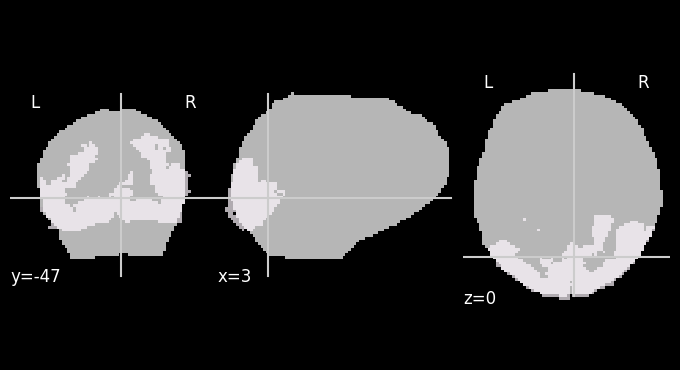

In [57]:
# =============================================================================
# ROI VISUALIZATION AND PROCESSING
# =============================================================================
# Load the ROI mask and visualize it overlaid on the brain mask
# Then process it for use in voxel selection
# =============================================================================

# Load the ROI mask
roi = nib.load(nsdgeneral_path)
print(roi.shape)

# Visualize the ROI overlaid on the brain mask
plot_roi(roi, bg_img=avg_mask)
plt.show()

In [58]:
# =============================================================================
# ROI MASK PROCESSING AND VOXEL SELECTION
# =============================================================================
# Process the ROI mask to identify which voxels should be included
# in the analysis, focusing on visual cortex regions
# =============================================================================

# Flatten the brain mask to 1D array
avg_mask = avg_mask.get_fdata().flatten()
print(f"total voxels (whole brain) = {int(avg_mask.sum())}")

# Load and process the ROI mask
roi = roi.get_fdata()
roi = roi.flatten()

# Apply the brain mask to the ROI (only keep ROI voxels that are also in brain)
roi = roi[avg_mask.astype(bool)]

# Handle any NaN values in the ROI
roi[np.isnan(roi)] = 0

# Convert to boolean mask
roi = roi.astype(bool)
print(f"nsdgeneral voxels = {roi.sum()}")


total voxels (whole brain) = 182242
nsdgeneral voxels = 19264


### ROI voxel exclusion

In [59]:
# =============================================================================
# APPLY ROI MASKING TO VOXEL DATA
# =============================================================================
# Use the ROI mask to select only the most relevant voxels for analysis
# This focuses the analysis on visual cortex regions and reduces
# computational complexity
# =============================================================================

# Print voxel counts before and after ROI exclusion
print(f"vox before ROI exclusion: {vox.shape}")

# Apply ROI mask to select only relevant voxels
vox = vox[:, roi]

print(f"vox after ROI exclusion: {vox.shape}")

# Check for and remove any NaN values that might have been introduced
if np.any(np.isnan(vox)):
    print("NaNs found! Removing voxels...")
    x, y = np.where(np.isnan(vox))
    vox = vox[:, np.setdiff1d(np.arange(vox.shape[-1]), y)]

vox before ROI exclusion: (693, 182242)
vox after ROI exclusion: (693, 19264)


## Reliability calculation
### Calculate reliability (corr between first and second presentation of same image) for every voxel

In [61]:
# =============================================================================
# VOXEL RELIABILITY CALCULATION
# =============================================================================
# This section calculates the reliability of each voxel by measuring
# how consistent its response is across repeated presentations of the same image
# Reliable voxels are essential for accurate brain decoding
# =============================================================================

# Extract pairs of repeated image presentations
# pairs_homog contains only the first two repeats of each image
pairs_homog = np.array([[p[0], p[1]] for p in pairs])


In [63]:


# =============================================================================
# COMPUTE VOXEL-WISE RELIABILITY SCORES
# =============================================================================
# For each voxel, calculate the correlation between its responses to
# the first and second presentation of the same image
# Higher correlations indicate more reliable voxels
# =============================================================================

# Z-score normalize the voxel responses for each pair
# This removes mean differences and scales variance for better correlation calculation
vox_pairs = utils.zscore(vox[pairs_homog])

# Initialize array to store reliability scores for each voxel
rels = np.full(vox.shape[-1], np.nan)

# Calculate reliability for each voxel
for v in tqdm(range(vox.shape[-1])):
    # Compute correlation between first and second presentation responses
    # [1,0] index extracts the off-diagonal correlation coefficient
    rels[v] = np.corrcoef(vox_pairs[:, 0, v], vox_pairs[:, 1, v])[1, 0]
    
# Alternative implementation (commented out) that shows the same calculation
# for v in tqdm(range(vox[0].shape[-1])):
#     rep0 = []
#     rep1 = []
# 
#     for vp in vox_pairs:
#         rep0.append(vp[0, v])
#         rep1.append(vp[1, v])
# 
#     rels[v] = np.corrcoef(rep0, rep1)[1, 0]

# Print reliability information
print("rels", rels.shape)

# Verify that no voxels have NaN reliability scores
assert np.sum(np.all(np.isnan(rels))) == 0

100%|██████████| 19264/19264 [00:00<00:00, 23555.68it/s]

rels (19264,)


### Create representational similarity matrix

In [64]:
# =============================================================================
# REPRESENTATIONAL SIMILARITY MATRIX (RSM) CREATION
# =============================================================================
# Create a matrix showing how similar the brain representations are
# between different images, using only reliable voxels
# This helps understand the structure of brain representations
# =============================================================================

# Create image × voxel × repetitions matrix
# Shape: (150, number_of_voxels, 2) where 2 represents the two repeats
vox0 = np.zeros((len(pairs_homog), vox.shape[-1], 2))
print(vox0.shape)

# Populate the matrix with voxel responses for each image pair
for ipair, pair in enumerate(tqdm(pairs_homog)):
    pair = pair[:2]  # Keep only the first two repeats for consistency
    i, j = pair
    vox0[ipair, :, :] = vox[pair].T

# Average across repetitions to get a single representation per image
vox_avg = vox0.mean(-1)

(112, 19264, 2)


100%|██████████| 112/112 [00:00<00:00, 3645.89it/s]


In [65]:
# =============================================================================
# RELIABILITY-THRESHOLDED REPRESENTATIONAL SIMILARITY MATRICES
# =============================================================================
# Create RSMs using different reliability thresholds to see how
# the quality of brain representations changes with voxel selection
# =============================================================================

# Define reliability thresholds for voxel selection
r_thresholds = np.array([.2])  # Only use voxels with reliability > 0.2

# Initialize RDM array for each reliability threshold
rdm = np.zeros((len(r_thresholds), len(pairs), len(pairs))) 

# Create RSM for each reliability threshold
for ir_thresh, r_thresh in enumerate(r_thresholds):
    print(f"reliability threshold = {r_thresh}")
    
    # For each pair of images, compute correlation between their brain representations
    for i in tqdm(range(len(pairs))):
        for j in range(len(pairs)):
            # Only use voxels above the reliability threshold
            rdm[ir_thresh, i, j] = np.corrcoef(vox_avg[i, rels > r_thresh], 
                                               vox_avg[j, rels > r_thresh])[0, 1]

# rdm has shape (number_of_thresholds, 150, 150)

reliability threshold = 0.2


100%|██████████| 112/112 [00:02<00:00, 49.08it/s]


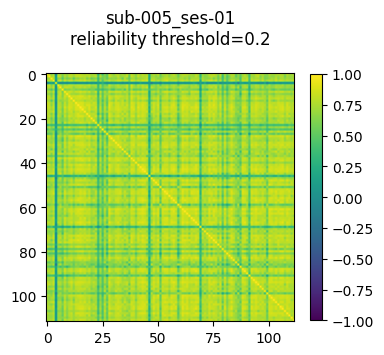

In [66]:
# =============================================================================
# RSM VISUALIZATION
# =============================================================================
# Visualize the representational similarity matrix to see the structure
# of brain representations across different images
# =============================================================================

thresh = .2  # Select which reliability threshold to visualize

plt.figure(figsize=(4, 4))
plt.imshow(rdm[np.where(r_thresholds == thresh)[0].item()], clim=(-1, 1))
plt.colorbar(shrink=0.8)
plt.title(f"{sub}_{session}\nreliability threshold={thresh}\n")
plt.show()

In [67]:
# =============================================================================
# RSM VALIDATION
# =============================================================================
# Verify that the diagonal of the RSM contains 1s (perfect self-similarity)
# and that the matrix is properly constructed
# =============================================================================

# Check that diagonal elements are 1 (perfect correlation with self)
for thresh in range(rdm.shape[0]):
    for img in range(rdm.shape[1]):
        assert np.isclose(rdm[thresh, img, img], 1)
        
# =============================================================================
# VOXEL SHAPE INFORMATION
# =============================================================================
# Print current voxel data shape for reference
# =============================================================================

vox.shape

(693, 19264)

In [68]:
# =============================================================================
# APPLY RELIABILITY THRESHOLDING
# =============================================================================
# Filter out unreliable voxels to improve model performance
# Only keep voxels with reliability above the threshold
# =============================================================================

# Print voxel counts before and after reliability thresholding
print(f"\nvox before reliability thresholding: {vox.shape}")

# Keep only voxels with reliability > 0.2
vox = vox[:, rels > .2]

print(f"\nvox after reliability thresholding: {vox.shape}")



vox before reliability thresholding: (693, 19264)

vox after reliability thresholding: (693, 2794)


In [69]:
# =============================================================================
# VERIFY DATA ALIGNMENT
# =============================================================================
# Ensure that images and voxel data still have matching dimensions
# after all the filtering and processing steps
# =============================================================================

print(images.shape)
print(vox.shape)
assert len(images) == len(vox)

torch.Size([693, 3, 224, 224])
(693, 2794)


112 112


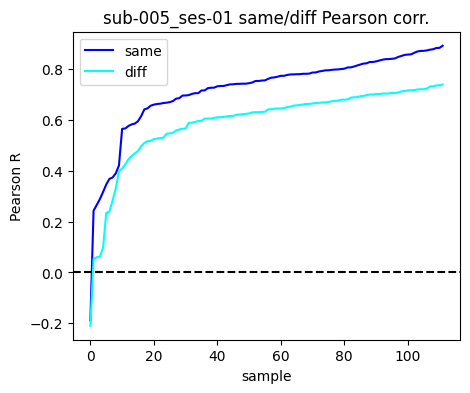

In [70]:
# =============================================================================
# CORRELATION ANALYSIS: SAME VS DIFFERENT IMAGES
# =============================================================================
# This section analyzes how well the brain can distinguish between:
# 1. Same image presentations (should have high correlation)
# 2. Different image presentations (should have lower correlation)
# This provides insight into the quality of brain representations
# =============================================================================

# Initialize arrays to store correlation values
same_corrs = []    # Correlations between same image presentations
diff_corrs = []    # Correlations between different image presentations

# Calculate correlations for each image pair
for isamp, samp in enumerate(vox[pairs_homog]):
    # =============================================================================
    # SAME IMAGE CORRELATIONS
    # =============================================================================
    # Calculate correlations between different presentations of the same image
    # These should be high if the brain representation is consistent
    # =============================================================================
    
    avg_same_img = []
    for i in range(samp.shape[0]):
        for j in range(i, samp.shape[0]):
            if i != j:  # Avoid self-correlation
                # Calculate correlation between two presentations of the same image
                avg_same_img.append(np.array([np.corrcoef(samp[i, :], samp[j, :])[0, 1]]))
    
    # Store the mean correlation for same image presentations
    same_corrs.append(np.mean(avg_same_img))
                       
    # =============================================================================
    # DIFFERENT IMAGE CORRELATIONS
    # =============================================================================
    # Calculate correlations between presentations of different images
    # These should be lower than same-image correlations
    # =============================================================================
    
    avg_diff_img = []
    for isamp_j, samp_j in enumerate(vox[pairs_homog]):
        if isamp_j != isamp:  # Compare with different images
            for i in range(samp_j.shape[0]):
                for j in range(i, samp_j.shape[0]):
                    if i != j:  # Avoid self-correlation
                        # Calculate correlation between different images
                        avg_diff_img.append(np.array([np.corrcoef(samp[i, :], samp_j[j, :])[0, 1]]))
                                    
    # Store the mean correlation for different image presentations
    # print(len(avg_diff_img))
    diff_corrs.append(np.mean(avg_diff_img))


# =============================================================================
# CORRELATION ANALYSIS RESULTS
# =============================================================================
# Convert to numpy arrays and print summary statistics
# =============================================================================

print(len(same_corrs), len(diff_corrs))
same_corrs = np.array(same_corrs)
diff_corrs = np.array(diff_corrs)

# =============================================================================
# VISUALIZE CORRELATION DISTRIBUTIONS
# =============================================================================
# Plot the distributions of same-image vs different-image correlations
# This shows how well the brain can distinguish between stimuli
# =============================================================================

plt.figure(figsize=(5, 4))
plt.title(f"{sub}_{session} same/diff Pearson corr.")
plt.plot(np.sort(same_corrs), c='blue', label='same')
plt.plot(np.sort(diff_corrs), c='cyan', label='diff')
plt.axhline(0, c='k', ls='--')
plt.legend()
plt.xlabel("sample")
plt.ylabel("Pearson R")
plt.show()

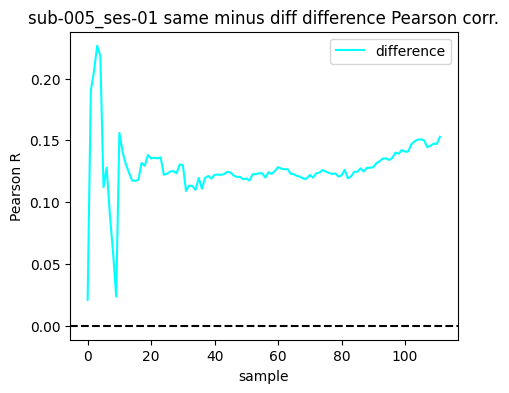

In [71]:
# =============================================================================
# CORRELATION DIFFERENCE ANALYSIS
# =============================================================================
# Plot the difference between same and different image correlations
# This shows the discriminability of brain representations
# =============================================================================

vox_pairs = utils.zscore(vox[pairs_homog])
plt.figure(figsize=(5, 4))
plt.title(f"{sub}_{session} same minus diff difference Pearson corr.")
plt.plot(np.sort(same_corrs) - np.sort(diff_corrs), c='cyan', label='difference')
plt.axhline(0, c='k', ls='--')
plt.legend()
plt.xlabel("sample")
plt.ylabel("Pearson R")
plt.show()


# Training MindEye

In [72]:
# =============================================================================
# TRAINING/TESTING SPLIT CONFIGURATION
# =============================================================================
# This section configures how the data is split for training and evaluation
# Different split strategies are available depending on the experimental design
# =============================================================================

utils.seed_everything(seed)  # Ensure reproducible results

if train_test_split == 'orig':
    # =============================================================================
    # ORIGINAL SPLIT STRATEGY
    # =============================================================================
    # Train = all images except images that were repeated
    # Test = average of the same-image presentations
    # This tests the model's ability to generalize to unseen images
    # =============================================================================
    
    imageTrain = np.arange(len(images))
    train_image_indices = np.array([item for item in imageTrain if item not in pairs.flatten()])
    test_image_indices = pairs
    print(len(train_image_indices), len(test_image_indices))
    assert len(train_image_indices) + len(test_image_indices) == len(image_idx)
    
elif train_test_split == 'MST':
    # =============================================================================
    # MST (MULTI-SESSION TEST) SPLIT STRATEGY
    # =============================================================================
    # Non-MST images are the training split
    # MST images are the test split
    # This tests cross-session generalization on carefully selected pairs
    # =============================================================================
    
    # Find MST image indices
    MST_idx = np.array([v for k, v in image_to_indices.items() if 'MST_pairs' in k])
    
    # Find non-MST image indices
    non_MST_idx = [v for k, v in image_to_indices.items() if 'MST_pairs' not in k]
    non_MST_idx = np.array([z for y in non_MST_idx for x in y for z in x])  # Flatten the indices
    
    # Assign training and testing indices
    train_image_indices = non_MST_idx
    test_image_indices = MST_idx.flatten()  # MST_idx contains the mapping for different test sets
    
    print(len(train_image_indices), len(test_image_indices))
    assert len(train_image_indices) + len(test_image_indices) == len(vox)
    
elif train_test_split == 'unique':
    # =============================================================================
    # UNIQUE SPLIT STRATEGY
    # =============================================================================
    # Train = repeated images (can learn from multiple presentations)
    # Test = unique images (tests generalization to unseen stimuli)
    # =============================================================================
    
    imageTest = np.arange(len(images))
    train_image_indices = pairs.flatten()
    test_image_indices = np.array([item for item in imageTest if item not in pairs.flatten()])
    print(len(train_image_indices), len(test_image_indices))
    assert len(train_image_indices) + len(test_image_indices) == len(image_idx)

elif train_test_split == 'cross':
    # =============================================================================
    # CROSS (SECTION) SPLIT STRATEGY
    # =============================================================================
    # Train = Non-MST images
    # Test = MST images from a separate session
    # =============================================================================
    
    # Find MST image indices
    MST_idx = np.array([v for k, v in image_to_indices.items() if 'MST_pairs' in k])
    
    # Find non-MST image indices
    non_MST_idx = [v for k, v in image_to_indices.items() if 'MST_pairs' not in k]
    non_MST_idx = np.array([z for y in non_MST_idx for x in y for z in x])  # Flatten the indices
    
    # Assign training and testing indices
    train_image_indices = non_MST_idx
    test_image_indices = MST_idx.flatten()  # MST_idx contains the mapping for different test sets
    
    print(len(train_image_indices), len(test_image_indices))
    assert len(train_image_indices) + len(test_image_indices) == len(vox)
    
else:
    raise Exception("invalid train_test_split")

# =============================================================================
# VERIFY SPLIT INTEGRITY
# =============================================================================
# Ensure that training and testing sets don't overlap
# This prevents data leakage and ensures proper evaluation
# =============================================================================

# TODO: Add assertion that verifies file names in train and test don't overlap
# This guards against repeats and ensures clean separation

for i in train_image_indices:
    assert i not in test_image_indices

569 124


In [74]:
# =============================================================================
# DATA NORMALIZATION FOR TRAINING
# =============================================================================
# This section normalizes the voxel data using statistics from the training set
# This ensures that the model receives properly scaled inputs and improves
# training stability and convergence
# =============================================================================

# Calculate mean and standard deviation from training data only
# This prevents data leakage from test set into training preprocessing
train_mean = np.mean(vox[train_image_indices], axis=0)
train_std = np.std(vox[train_image_indices], axis=0)

# Apply Z-score normalization using training statistics
# This transforms the data to have mean=0 and std=1
vox = utils.zscore(vox, train_mean=train_mean, train_std=train_std)
print("voxels have been zscored")

# Verify normalization worked correctly
print(vox[:, 0].mean(), vox[:, 0].std())
print("vox", vox.shape)

voxels have been zscored
-0.11855641 1.0033551
vox (693, 2794)


In [75]:
# =============================================================================
# DATA TYPE CONVERSION TO PYTORCH TENSORS
# =============================================================================
# Convert numpy arrays to PyTorch tensors for neural network training
# This enables GPU acceleration and automatic differentiation
# =============================================================================

# Note: The commented code below shows validation logic for deleted indices
# This ensures that image names and data match when removing specific images
# for idx in deleted_indices:
#     # check image names to be deleted match
#     original_name = vox_image_dict[idx]
#     matching_indices = [i for i in deleted_indices if vox_image_dict[i] == original_name]
#     assert all(vox_image_dict[i] == original_name for i in matching_indices), \
#         f"Mismatch in image names for deleted indices {matching_indices}"
# 
#     # check image data to be deleted match
#     base_image = images[matching_indices[0]]  # Reference image
#     for i in matching_indices[1:]:
#         assert np.array_equal(base_image, images[i]), \
#             f"Mismatch in image data for {vox_image_dict[i]} at index {i}"
# 
# images = images[kept_indices]


In [76]:
# =============================================================================
# FINAL DATA PREPARATION
# =============================================================================
# Convert all data to PyTorch tensors and verify alignment
# This is the final step before model training begins
# =============================================================================

# Convert images to PyTorch tensor
images = torch.Tensor(images)

# Convert voxel data to PyTorch tensor
vox = torch.Tensor(vox)

# Verify that images and voxel data have matching dimensions
assert len(images) == len(vox)


In [77]:
# =============================================================================
# MULTI-GPU DISTRIBUTED TRAINING CONFIGURATION
# =============================================================================
# This section sets up distributed training across multiple GPUs
# using the Accelerate library for efficient multi-device training
# =============================================================================

### Multi-GPU config ###
from accelerate import Accelerator, DeepSpeedPlugin

# Get local rank from environment (for distributed training)
local_rank = os.getenv('RANK')
if local_rank is None: 
    local_rank = 0
else:
    local_rank = int(local_rank)
print("LOCAL RANK ", local_rank)  

# Set data type for mixed precision training
data_type = torch.float32  # Change depending on your mixed_precision

# Initialize the Accelerator for distributed training
accelerator = Accelerator(split_batches=False)
batch_size = 8

LOCAL RANK  0


In [79]:
# =============================================================================
# DEVICE AND DISTRIBUTED TRAINING SETUP
# =============================================================================
# This section configures the training environment including:
# - Device selection (CPU/GPU)
# - Distributed training parameters
# - Mixed precision settings
# - Process management
# =============================================================================

# Get process ID for debugging and monitoring
print("PID of this process =", os.getpid())

# Get the device that this process should use
device = accelerator.device
print("device:", device)

# Get distributed training information
world_size = accelerator.state.num_processes
distributed = not accelerator.state.distributed_type == 'NO'
num_devices = torch.cuda.device_count()

# Calculate global batch size across all devices
global_batch_size = batch_size * num_devices
print("global_batch_size", global_batch_size)

# Handle case where no GPUs are available
if num_devices == 0 or not distributed: 
    num_devices = 1

# Set number of workers for data loading
num_workers = num_devices
print(accelerator.state)

# =============================================================================
# MIXED PRECISION CONFIGURATION
# =============================================================================
# Set data type to match your mixed precision configuration
# This is automatically set based on deepspeed config
# =============================================================================

if accelerator.mixed_precision == "bf16":
    data_type = torch.bfloat16
elif accelerator.mixed_precision == "fp16":
    data_type = torch.float16
else:
    data_type = torch.float32

# Print distributed training configuration
print("distributed =", distributed, "num_devices =", num_devices, 
      "local rank =", local_rank, "world size =", world_size, 
      "data_type =", data_type)

# Only print from main process in distributed training
print = accelerator.print


PID of this process = 1541181
device: cuda
global_batch_size 8
Distributed environment: DistributedType.NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: no

distributed = False num_devices = 1 local rank = 0 world size = 1 data_type = torch.float32


In [94]:
'-'.join(ses_list)

'ses-01'

In [106]:
# =============================================================================
# MODEL TRAINING CONFIGURATIONS
# =============================================================================
# This section sets up the training parameters and configurations
# for the MindEye model, including hyperparameters and training strategies
# =============================================================================

# If running this interactively, can specify jupyter_args here for argparser to use
if utils.is_interactive():
    # Set model name for this training run
    str_ses_list = '-'.join(ses_list)
    model_name = f'MST-testing_{sub}_train-{str_ses_list}_{num_runs_to_train}-runs'  # 'sub-001_multi_bs24_MST_rishab_MSTsplit_remove_150_random_seed_0'
    print("model_name:", model_name)
    
    # global_batch_size and batch_size should already be defined in the above cells
    # other variables can be specified in the following string:
    # jupyter_args = f"--data_path=/scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2 --model_name={model_name}"

    # =============================================================================
    # JUPYTER ARGUMENTS FOR INTERACTIVE TRAINING
    # =============================================================================
    # These arguments configure the training run when running in Jupyter
    # They specify model architecture, training parameters, and data paths
    # =============================================================================
    
    jupyter_args = f"--data_path=/scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2 \
                    --model_name={model_name} \
                    --no-multi_subject --subj=1 --batch_size={batch_size} \
                    --hidden_dim=1024 --clip_scale=1. \
                    --no-blurry_recon --blur_scale=.5 \
                    --no-use_prior --prior_scale=30 \
                    --n_blocks=4 --max_lr=3e-4 --mixup_pct=.33 --num_epochs=30 --no-use_image_aug \
                    --ckpt_interval=999 --no-ckpt_saving --new_test \
                    --multisubject_ckpt=/scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2/train_logs/multisubject_subj01_1024hid_nolow_300ep"
    print(jupyter_args)
    jupyter_args = jupyter_args.split()


model_name: MST-testing_sub-005_train-ses-01_5-runs
--data_path=/scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2                     --model_name=MST-testing_sub-005_train-ses-01_5-runs                     --no-multi_subject --subj=1 --batch_size=8                     --hidden_dim=1024 --clip_scale=1.                     --no-blurry_recon --blur_scale=.5                     --no-use_prior --prior_scale=30                     --n_blocks=4 --max_lr=3e-4 --mixup_pct=.33 --num_epochs=30 --no-use_image_aug                     --ckpt_interval=999 --no-ckpt_saving --new_test                     --multisubject_ckpt=/scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2/train_logs/multisubject_subj01_1024hid_nolow_300ep


In [107]:
# =============================================================================
# COMMAND LINE ARGUMENT PARSING
# =============================================================================
# Set up argument parser for command-line configuration
# This allows the script to be run with different parameters
# =============================================================================

parser = argparse.ArgumentParser(description="Model Training Configuration")

# =============================================================================
# BASIC MODEL PARAMETERS
# =============================================================================
parser.add_argument(
    "--model_name", type=str, default="testing",
    help="name of model, used for ckpt saving and wandb logging (if enabled)",
)
parser.add_argument(
    "--data_path", type=str, default="/weka/proj-fmri/shared/natural-scenes-dataset",
    help="Path to where NSD data is stored / where to download it to",
)
parser.add_argument(
    "--subj", type=int, default=1, choices=[1, 2, 3, 4, 5, 6, 7, 8],
    help="Validate on which subject?",
)
parser.add_argument(
    "--multisubject_ckpt", type=str, default=None,
    help="Path to pre-trained multisubject model to finetune a single subject from. multisubject must be False.",
)
parser.add_argument(
    "--num_sessions", type=int, default=0,
    help="Number of training sessions to include (if multi_subject, this variable doesnt matter)",
)

# =============================================================================
# TRAINING STRATEGY PARAMETERS
# =============================================================================
parser.add_argument(
    "--use_prior", action=argparse.BooleanOptionalAction, default=False,
    help="whether to train diffusion prior (True) or just rely on retrieval part of the pipeline (False)",
)
parser.add_argument(
    "--batch_size", type=int, default=32,
    help="Batch size can be increased by 10x if only training v2c and not diffusion diffuser",
)
parser.add_argument(
    "--wandb_log", action=argparse.BooleanOptionalAction, default=False,
    help="whether to log to wandb",
)
parser.add_argument(
    "--resume_from_ckpt", action=argparse.BooleanOptionalAction, default=False,
    help="if not using wandb and want to resume from a ckpt",
)

# =============================================================================
# LOGGING AND MONITORING PARAMETERS
# =============================================================================
parser.add_argument(
    "--wandb_project", type=str, default="stability",
    help="wandb project name",
)
parser.add_argument(
    "--mixup_pct", type=float, default=.33,
    help="proportion of way through training when to switch from BiMixCo to SoftCLIP",
)
parser.add_argument(
    "--low_mem", action=argparse.BooleanOptionalAction, default=False,
    help="whether to preload images to cpu to speed things up but consume more memory",
)

# =============================================================================
# MODEL ARCHITECTURE PARAMETERS
# =============================================================================
parser.add_argument(
    "--blurry_recon", action=argparse.BooleanOptionalAction, default=True,
    help="whether to output blurry reconstructions",
)
parser.add_argument(
    "--blur_scale", type=float, default=.5,
    help="multiply loss from blurry recons by this number",
)
parser.add_argument(
    "--clip_scale", type=float, default=1.,
    help="multiply contrastive loss by this number",
)
parser.add_argument(
    "--prior_scale", type=float, default=30,
    help="multiply diffusion prior loss by this",
)
parser.add_argument(
    "--use_image_aug", action=argparse.BooleanOptionalAction, default=True,
    help="whether to use image augmentation",
)

# =============================================================================
# TRAINING SCHEDULE PARAMETERS
# =============================================================================
parser.add_argument(
    "--num_epochs", type=int, default=120,
    help="number of epochs of training",
)
parser.add_argument(
    "--multi_subject", action=argparse.BooleanOptionalAction, default=False,
)
parser.add_argument(
    "--new_test", action=argparse.BooleanOptionalAction, default=True,
)
parser.add_argument(
    "--n_blocks", type=int, default=2,
)
parser.add_argument(
    "--hidden_dim", type=int, default=1024,
)
parser.add_argument(
    "--seq_past", type=int, default=0,
)
parser.add_argument(
    "--seq_future", type=int, default=0,
)
parser.add_argument(
    "--lr_scheduler_type", type=str, default='cycle', choices=['cycle', 'linear'],
)
parser.add_argument(
    "--ckpt_saving", action=argparse.BooleanOptionalAction, default=True,
)
parser.add_argument(
    "--ckpt_interval", type=int, default=5,
    help="save backup ckpt and reconstruct every x epochs",
)
parser.add_argument(
    "--seed", type=int, default=42,
)
parser.add_argument(
    "--max_lr", type=float, default=3e-4,
)
parser.add_argument(
    "--session3_data_path", type=str, default=None,
    help="Path to session 3 data for MST testing (optional)",
)
parser.add_argument(
    "--auto_test_after_training", action=argparse.BooleanOptionalAction, default=True,
    help="Whether to automatically test on session 3 MST data after training",
)
parser.add_argument(
    "--enable_run_limiting", action=argparse.BooleanOptionalAction, default=True,
    help="Whether to limit training data to the specified number of runs",
)

# Parse arguments (either from command line or jupyter)
if utils.is_interactive():
    args = parser.parse_args(jupyter_args)
else:
    args = parser.parse_args()

# =============================================================================
# CREATE GLOBAL VARIABLES FROM ARGUMENTS
# =============================================================================
# Convert parsed arguments to global variables for easy access
# =============================================================================

# create global variables without the args prefix
for attribute_name in vars(args).keys():
    globals()[attribute_name] = getattr(args, attribute_name)
    
# =============================================================================
# IMAGE AUGMENTATION SETUP
# =============================================================================
# Import and configure image augmentation if enabled
# =============================================================================

if use_image_aug or blurry_recon:
    import kornia
    import kornia.augmentation as K
    from kornia.augmentation.container import AugmentationSequential

if use_image_aug:
    # Configure color jittering augmentation
    img_augment = AugmentationSequential(
        kornia.augmentation.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1, p=0.3),
        same_on_batch=False,
        data_keys=["input"],
    )
    # Define the blurring augmentations
    blur_augment = K.RandomGaussianBlur(kernel_size=(21, 21), sigma=(51.0, 51.0), p=1.)
    
# =============================================================================
# SUBJECT LIST CONFIGURATION
# =============================================================================
# Configure which subjects to use for training
# =============================================================================

if multi_subject:
    # Use all subjects except the validation subject
    subj_list = np.arange(1, 9)
    subj_list = subj_list[subj_list != subj]
else:
    # Single subject training
    subj_list = [subj]

print("subj_list", subj_list, "num_sessions", num_sessions)

subj_list [1] num_sessions 0


In [116]:
# =============================================================================
# OUTPUT DIRECTORY SETUP
# =============================================================================
# Create output directory for model checkpoints and logs
# =============================================================================

user_name = 'wg7536'
ckpt_saving = True
outdir = os.path.abspath(f'/scratch/gpfs/{user_name}/mindeye_testing/tmp/train_logs/{model_name}')
eval_dir = os.path.join(outdir, 'eval')

if not os.path.exists(outdir) and ckpt_saving:
    os.makedirs(outdir, exist_ok=True)

if not os.path.exists(eval_dir) and ckpt_saving:
    os.makedirs(eval_dir, exist_ok=True)

## Prep data, models, and dataloaders

In [118]:
# =============================================================================
# CHECKPOINT SAVING AND EVALUATION DATA PREPARATION
# =============================================================================
# This section saves important data for later evaluation and analysis
# including MST information, training/testing splits, and processed data
# =============================================================================

if ckpt_saving:
    # =============================================================================
    # SAVE MST INFORMATION FOR EVALUATION
    # =============================================================================
    # Save MST_ID and pairmate indices for 2-alternative forced-choice retrieval evaluation
    # This is essential for the MST evaluation protocol
    # =============================================================================
    
    if 'MST' in model_name:
        eval_dir = get_flag("eval_dir", eval_dir, cast=str)
        print('saving MST info in', eval_dir)
        
        # Create evaluation directory if it doesn't exist
        if not os.path.exists(eval_dir):
            os.mkdir(eval_dir)

        # Save MST identification arrays
        np.save(f"{eval_dir}/MST_ID.npy", MST_ID)
        np.save(f"{eval_dir}/MST_pairmate_indices.npy", MST_pairmate_indices)

    # =============================================================================
    # SAVE IMAGE REMOVAL INFORMATION
    # =============================================================================
    # If random image removal was used, save the list of removed images
    # This is important for reproducibility and analysis
    # =============================================================================
    
    if remove_random_n:
        np.save(f"{eval_dir}/imgs_to_remove.npy", imgs_to_remove)

    # =============================================================================
    # SAVE TRAINING/TESTING SPLITS AND PROCESSED DATA
    # =============================================================================
    # Save the final training and testing indices along with the processed
    # images and voxel data for later analysis
    # =============================================================================
    
    np.save(f"{eval_dir}/train_image_indices.npy", train_image_indices)
    np.save(f"{eval_dir}/test_image_indices.npy", test_image_indices)
    np.save(f"{eval_dir}/images.npy", images)
    np.save(f"{eval_dir}/vox.npy", vox)

saving MST info in /scratch/gpfs/wg7536/mindeye_testing/tmp/train_logs/MST-testing_sub-005_train-ses-01_5-runs/eval


### Creating wds dataloader, preload betas and all 73k possible images

In [119]:
# =============================================================================
# DATALOADER CONFIGURATION AND BATCH SIZE CALCULATION
# =============================================================================
# This section sets up the data loaders for training and calculates
# the appropriate batch sizes and iteration counts
# =============================================================================

def my_split_by_node(urls): 
    return urls

# Initialize list to store number of voxels for each subject
num_voxels_list = []

# =============================================================================
# MULTI-SUBJECT VS SINGLE-SUBJECT CONFIGURATION
# =============================================================================
# Configure training parameters based on whether we're training on
# multiple subjects or just one subject
# =============================================================================

if multi_subject:
    # For multi-subject training, use predefined session counts
    nsessions_allsubj = np.array([40, 40, 32, 30, 40, 32, 40, 30])
    num_samples_per_epoch = (750 * 40) // num_devices 
else:
    # For single-subject training, use the actual number of training samples
    # num_samples_per_epoch = (750 * num_sessions) // num_devices 
    num_samples_per_epoch = len(train_image_indices)

# =============================================================================
# BATCH SIZE AND ITERATION CALCULATION
# =============================================================================
# Calculate appropriate batch sizes and iteration counts for training
# =============================================================================

print("dividing batch size by subj_list, which will then be concatenated across subj during training...") 

# Divide batch size by number of subjects for multi-subject training
batch_size = batch_size // len(subj_list)

# Calculate number of iterations per epoch
num_iterations_per_epoch = num_samples_per_epoch // (batch_size * len(subj_list))

print("batch_size =", batch_size, "num_iterations_per_epoch =", num_iterations_per_epoch, 
      "num_samples_per_epoch =", num_samples_per_epoch)


dividing batch size by subj_list, which will then be concatenated across subj during training...
batch_size = 8 num_iterations_per_epoch = 71 num_samples_per_epoch = 569


In [120]:
# =============================================================================
# TRAINING DATA LOADER CREATION
# =============================================================================
# Create data loaders for training data for each subject
# =============================================================================

train_data = {}
train_dl = {}

# Create training dataset for the current subject
train_data[f'subj0{subj}'] = torch.utils.data.TensorDataset(torch.tensor(train_image_indices))

# Create testing dataset
test_data = torch.utils.data.TensorDataset(torch.tensor(test_image_indices))


In [121]:
# =============================================================================
# VOXEL DATA ORGANIZATION AND DATALOADER SETUP
# =============================================================================
# Organize voxel data by subject and create data loaders
# This enables efficient batch processing during training
# =============================================================================

# Initialize dictionaries to store voxel information for each subject
num_voxels = {}
voxels = {}

# Process each subject in the subject list
for s in subj_list:
    print(f"Training with {num_sessions} sessions")
    
    # Create data loader for this subject
    train_dl = torch.utils.data.DataLoader(train_data[f'subj0{s}'], 
                                         batch_size=batch_size, 
                                         shuffle=True, 
                                         drop_last=True, 
                                         pin_memory=True)

    # Store voxel count and data for this subject
    num_voxels_list.append(vox[0].shape[-1])
    num_voxels[f'subj0{s}'] = vox[0].shape[-1]
    voxels[f'subj0{s}'] = vox
    print(f"num_voxels for subj0{s}: {num_voxels[f'subj0{s}']}")

print("Loaded all subj train dls and vox!\n")

# =============================================================================
# TESTING DATA LOADER SETUP
# =============================================================================
# Set up testing data loader for evaluation
# =============================================================================

# Validate only on one subject
if multi_subject: 
    subj = subj_list[0]  # Can't validate on the actual held out person, so pick first in subj_list

# Create testing data loader
test_dl = torch.utils.data.DataLoader(test_data, batch_size=24, shuffle=False, 
                                     drop_last=True, pin_memory=True)

print(f"Loaded test dl for subj{subj}!\n")

Training with 0 sessions
num_voxels for subj01: 2794
Loaded all subj train dls and vox!

Loaded test dl for subj1!



## Load models
### CLIP image embeddings  model

In [124]:
# =============================================================================
# CLIP IMAGE EMBEDDING MODEL LOADING
# =============================================================================
# Load the CLIP model that provides image understanding capabilities
# CLIP (Contrastive Language-Image Pre-training) creates rich image representations
# that the MindEye model will learn to predict from brain activity
# =============================================================================

## USING OpenCLIP ViT-bigG ###
sys.path.append('generative_models/')
import sgm
from generative_models.sgm.modules.encoders.modules import FrozenOpenCLIPImageEmbedder
# from generative_models.sgm.models.diffusion import DiffusionEngine
# from omegaconf import OmegaConf

try:
    print(clip_img_embedder)
except:
    # Initialize OpenCLIP ViT-bigG model for image encoding
    clip_img_embedder = FrozenOpenCLIPImageEmbedder(
        arch="ViT-bigG-14",                    # Vision Transformer architecture
        version="laion2b_s39b_b160k",          # Pre-trained weights version
        output_tokens=True,                     # Output token-level representations
        only_tokens=True,                       # Only return tokens, not pooled features
    )
    clip_img_embedder.to(device)

# Set CLIP model dimensions
clip_seq_dim = 256      # Number of tokens in sequence
clip_emb_dim = 1664     # Dimension of each token embedding

# ## USING OPEN AI CLIP ViT-L ###
# Alternative CLIP implementation (commented out)
# import clip
# try:
#     print(clip_model)
# except:
#     clip_model, preprocess = clip.load("ViT-L/14", device=device)
#     preprocess = transforms.Compose([
#         transforms.Resize(224, interpolation=transforms.InterpolationMode.BILINEAR),
#         transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
#                              std=[0.26862954, 0.26130258, 0.27577711]),
#     ])
# def clip_img_embedder(image):
#     preproc_img = preprocess(image)
#     return clip_model.encode_image(preproc_img)
# clip_seq_dim = 1
# clip_emb_dim = 768


### MindEye modules

In [125]:
# =============================================================================
# MIND EYE MODEL ARCHITECTURE SETUP
# =============================================================================
# Initialize the MindEye model that will learn to map brain activity
# to CLIP image representations
# =============================================================================

model = utils.prepare_model_and_training(
    num_voxels_list=num_voxels_list,    # Number of voxels for each subject
    n_blocks=n_blocks,                   # Number of transformer blocks
    hidden_dim=hidden_dim,               # Hidden dimension of transformer
    clip_emb_dim=clip_emb_dim,           # CLIP embedding dimension
    clip_seq_dim=clip_seq_dim,           # CLIP sequence dimension
    use_prior=use_prior,                 # Whether to use diffusion prior
    clip_scale=clip_scale                # Scaling factor for CLIP loss
)


MindEyeModule()
param counts:
2,862,080 total
2,862,080 trainable
param counts:
2,862,080 total
2,862,080 trainable
param counts:
453,360,280 total
453,360,280 trainable
param counts:
456,222,360 total
456,222,360 trainable


In [126]:
# =============================================================================
# MODEL COMPONENT TESTING
# =============================================================================
# Test that the model components work correctly with sample data
# This helps catch configuration errors early
# =============================================================================

# Test ridge regression component with fake data
b = torch.randn((2, 1, num_voxels_list[0]))
print(b.shape, model.ridge(b, 0).shape)

torch.Size([2, 1, 2794]) torch.Size([2, 1, 1024])


In [129]:
#=============================================================================
# BACKBONE NETWORK TESTING
# =============================================================================
# Test the backbone transformer network with sample data
# This verifies the model architecture is properly configured
# =============================================================================

# Test that the model works on some fake data
b = torch.randn((2, 1, hidden_dim))
print("b.shape", b.shape)

# Test backbone network forward pass
backbone_, clip_, blur_ = model.backbone(b)
print(backbone_.shape, clip_.shape, blur_[0].shape, blur_[1].shape)

b.shape torch.Size([2, 1, 1024])
torch.Size([2, 256, 1664]) torch.Size([2, 256, 1664]) torch.Size([1]) torch.Size([1])


### Adding diffusion prior + unCLIP if use_prior=True

In [130]:
# =============================================================================
# DIFFUSION PRIOR MODEL SETUP (OPTIONAL)
# =============================================================================
# If enabled, this adds a diffusion prior network that can generate
# image reconstructions from brain activity patterns
# This enhances the model's ability to create visual outputs
# =============================================================================

if use_prior:
    from models import *

    # =============================================================================
    # DIFFUSION PRIOR NETWORK ARCHITECTURE
    # =============================================================================
    # Set up the diffusion prior network parameters
    # This network learns to generate CLIP embeddings from brain representations
    # =============================================================================
    
    # Network configuration
    out_dim = clip_emb_dim        # Output dimension matches CLIP embeddings
    depth = 6                      # Number of transformer layers
    dim_head = 52                  # Dimension per attention head
    heads = clip_emb_dim // 52     # Number of attention heads (must divide clip_emb_dim)
    timesteps = 100                # Number of diffusion timesteps

    # Initialize the versatile diffusion prior network
    prior_network = VersatileDiffusionPriorNetwork(
        dim=out_dim,               # Input/output dimension
        depth=depth,               # Number of transformer layers
        dim_head=dim_head,         # Dimension per attention head
        heads=heads,               # Number of attention heads
        causal=False,              # Non-causal attention (can attend to all positions)
        num_tokens=clip_seq_dim,   # Number of tokens in sequence
        learned_query_mode="pos_emb"  # Use learned positional embeddings
    )

    # =============================================================================
    # BRAIN DIFFUSION PRIOR INTEGRATION
    # =============================================================================
    # Wrap the prior network in a BrainDiffusionPrior that integrates
    # with the MindEye pipeline
    # =============================================================================
    
    model.diffusion_prior = BrainDiffusionPrior(
        net=prior_network,                    # The prior network
        image_embed_dim=out_dim,              # Dimension of image embeddings
        condition_on_text_encodings=False,    # No text conditioning in this setup
        timesteps=timesteps,                  # Number of diffusion steps
        cond_drop_prob=0.2,                  # Probability of dropping conditioning
        image_embed_scale=None,               # No scaling of image embeddings
    )
    
    # Print model parameter counts for monitoring
    utils.count_params(model.diffusion_prior)
    utils.count_params(model)


### Setup optimizer / lr / ckpt saving

In [131]:
# =============================================================================
# OPTIMIZER AND LEARNING RATE SCHEDULER SETUP
# =============================================================================
# Configure the optimization strategy for training the MindEye model
# This includes optimizer selection, learning rate scheduling, and
# parameter grouping for different weight decay strategies
# =============================================================================

# Define parameters that should not have weight decay applied
# This is a common practice for bias terms and normalization layers
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']

# =============================================================================
# PARAMETER GROUPING FOR DIFFERENT WEIGHT DECAY STRATEGIES
# =============================================================================
# Group parameters by their type to apply different optimization strategies
# - Ridge regression parameters: high weight decay for regularization
# - Backbone parameters: standard weight decay
# - Diffusion prior parameters (if enabled): standard weight decay
# =============================================================================

opt_grouped_parameters = [
    # Ridge regression layer: high weight decay for regularization
    {'params': [p for n, p in model.ridge.named_parameters()], 'weight_decay': 1e-2},
    
    # Backbone network: standard weight decay for most parameters
    {'params': [p for n, p in model.backbone.named_parameters() 
                if not any(nd in n for nd in no_decay)], 'weight_decay': 1e-2},
    
    # Backbone network: no weight decay for bias and normalization parameters
    {'params': [p for n, p in model.backbone.named_parameters() 
                if any(nd in n for nd in no_decay)], 'weight_decay': 0.0},
]
# model.backbone.requires_grad_(False)

if use_prior:
    opt_grouped_parameters.extend([
        # Diffusion prior: standard weight decay for most parameters
        {'params': [p for n, p in model.diffusion_prior.named_parameters() 
                    if not any(nd in n for nd in no_decay)], 'weight_decay': 1e-2},
        
        # Diffusion prior: no weight decay for bias and normalization parameters
        {'params': [p for n, p in model.diffusion_prior.named_parameters() 
                    if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ])

optimizer = torch.optim.AdamW(opt_grouped_parameters, lr=max_lr)

# =============================================================================
# LEARNING RATE SCHEDULER CONFIGURATION
# =============================================================================
# Configure learning rate scheduling strategy
# Options: linear decay or cyclic learning rate
# =============================================================================

if lr_scheduler_type == 'linear':
    # Linear learning rate decay over the entire training period
    lr_scheduler = torch.optim.lr_scheduler.LinearLR(
        optimizer,
        total_iters=int(np.floor(num_epochs*num_iterations_per_epoch)),
        last_epoch=-1
    )
elif lr_scheduler_type == 'cycle':
    # Cyclic learning rate with warmup and decay
    if num_iterations_per_epoch == 0:
        num_iterations_per_epoch = 1
    
    total_steps = int(np.floor(num_epochs * num_iterations_per_epoch))
    print("total_steps", total_steps)
    
    lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer, 
        max_lr=max_lr,                    # Maximum learning rate
        total_steps=total_steps,          # Total training steps
        final_div_factor=1000,            # Final learning rate = max_lr/1000
        last_epoch=-1, 
        pct_start=2/num_epochs           # Warmup for first 2 epochs
    )
    
def save_ckpt(tag):
    ckpt_path = outdir+f'/{tag}.pth'
    if accelerator.is_main_process:
        unwrapped_model = accelerator.unwrap_model(model)
        torch.save({
            'epoch': epoch,
            'model_state_dict': unwrapped_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'lr_scheduler': lr_scheduler.state_dict(),
            'train_losses': losses,
            'test_losses': test_losses,
            'lrs': lrs,
            }, ckpt_path)
    print(f"\n---saved {outdir}/{tag} ckpt!---\n")

def load_ckpt(tag,load_lr=True,load_optimizer=True,load_epoch=True,strict=True,outdir=outdir,multisubj_loading=False): 
    print(f"\n---loading {outdir}/{tag}.pth ckpt---\n")
    checkpoint = torch.load(outdir+'/last.pth', map_location='cpu')
    state_dict = checkpoint['model_state_dict']
    if multisubj_loading: # remove incompatible ridge layer that will otherwise error
        state_dict.pop('ridge.linears.0.weight',None)
    model.load_state_dict(state_dict, strict=strict)
    if load_epoch:
        globals()["epoch"] = checkpoint['epoch']
        print("Epoch",epoch)
    if load_optimizer:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    if load_lr:
        lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])
    del checkpoint

print("\nDone with model preparations!")
num_params = utils.count_params(model)

total_steps 2130

Done with model preparations!
param counts:
456,222,360 total
456,222,360 trainable


# Wandb

In [132]:
if local_rank==0 and wandb_log: # only use main process for wandb logging
    import wandb
    import time
    
    wandb_project = 'rtmindeye'
    print(f"wandb {wandb_project} run {model_name}")

    # Need to configure wandb beforehand in terminal with "wandb init"!
    wandb_config = {
        "model_name": model_name,
        "global_batch_size": global_batch_size,
        "batch_size": batch_size,
        "num_epochs": num_epochs,
        "num_sessions": num_sessions,
        "num_params": num_params,
        "clip_scale": clip_scale,
        "prior_scale": prior_scale,
        "blur_scale": blur_scale,
        "use_image_aug": use_image_aug,
        "max_lr": max_lr,
        "mixup_pct": mixup_pct,
        "num_samples_per_epoch": num_samples_per_epoch,
        "ckpt_interval": ckpt_interval,
        "ckpt_saving": ckpt_saving,
        "seed": seed,  # SLURM array task ID
        "distributed": distributed,
        "num_devices": num_devices,
        "world_size": world_size,
    }
    print("wandb_config:\n", wandb_config)
    print("wandb_id:", model_name)

    # Initialize wandb
    wandb.init(
        id=model_name,
        project=wandb_project,
        name=model_name,
        config=wandb_config,
        resume="allow",
        save_code=True,
    )

    # Get SLURM job & array ID
    slurm_job_id = utils.get_slurm_job()
    slurm_array_id = seed  # seed corresponds to SLURM_ARRAY_TASK_ID

    # Define SLURM log paths
    log_dir = "slurms"
    log_files = [
        f"{log_dir}/{slurm_job_id}_{slurm_array_id}.out",
        f"{log_dir}/{slurm_job_id}_{slurm_array_id}.err",
    ]

    # Ensure logs exist before logging them
    for log_file in log_files:
        wait_time = 0
        while not os.path.exists(log_file) and wait_time < 60:  # Wait max 60s
            time.sleep(5)
            wait_time += 5

    # Log SLURM logs as artifacts
    artifact = wandb.Artifact(f"slurm_logs_{slurm_job_id}_{slurm_array_id}", type="logs")
    for log_file in log_files:
        if os.path.exists(log_file):
            artifact.add_file(log_file)

    wandb.log_artifact(artifact)
else:
    wandb_log = False

# Train the model

In [134]:
epoch = 0
losses, test_losses, lrs = [], [], []
best_test_loss = 1e9
torch.cuda.empty_cache()

In [135]:
# load multisubject stage1 ckpt if set
if multisubject_ckpt is not None and not resume_from_ckpt:
    load_ckpt("last",outdir=multisubject_ckpt,load_lr=False,load_optimizer=False,load_epoch=False,strict=False,multisubj_loading=True)


---loading /scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2/train_logs/multisubject_subj01_1024hid_nolow_300ep/last.pth ckpt---

[2025-08-24 17:34:20,821] [INFO] [real_accelerator.py:191:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [136]:
# checkpoint = torch.load(multisubject_ckpt+'/last.pth', map_location='cpu')
# state_dict = checkpoint['model_state_dict']
# model.load_state_dict(state_dict, strict=False)

In [138]:
# train_dls = [train_dl[f'subj0{s}'] for s in subj_list]

model, optimizer, train_dl, lr_scheduler = accelerator.prepare(model, optimizer, train_dl, lr_scheduler)
# leaving out test_dl since we will only have local_rank 0 device do evals


In [145]:
# =============================================================================
# TRAINING TRIGGER CHECK AND RUN LIMITING
# =============================================================================
# Check if we have enough runs to proceed with training AND limit the data
# to only use the specified number of runs
# =============================================================================

should_trigger_training = n_runs >= num_runs_to_train

# Check if training should be triggered based on the number of runs
training_triggered = should_trigger_training
print(f"\n===Training Trigger Check===")
print(f"Number of runs across sessions: {n_runs}")
print(f"Training threshold: {num_runs_to_train}")
print(f"Training triggered: {training_triggered}")



===Training Trigger Check===
Number of runs across sessions: 11
Training threshold: 5
Training triggered: True


In [149]:
def limit_runs_for_training(n_runs, num_runs_to_train):
    """
    Limit the number of runs used for training.
    
    Args:
        n_runs: Total number of runs available
        num_runs_to_train: Maximum number of runs to use for training
    
    Returns:
        int: Number of runs to actually use for training
    """
    if n_runs <= num_runs_to_train:
        return n_runs
    
    print(f"Limiting training to {num_runs_to_train} runs out of {n_runs} available runs")
    return num_runs_to_train

def sample_runs_for_training(image_names, is_new_run, num_runs_to_use, seed=None):
    """
    Select the first N runs for training based on the run limit.
    
    Args:
        image_names: Array of image names for each trial
        is_new_run: Boolean array indicating start of new fMRI runs
        num_runs_to_use: Number of runs to use for training
        seed: Random seed (ignored, kept for compatibility)
    
    Returns:
        tuple: (selected_run_indices, selected_trial_indices)
    """
    # Find the start indices of each run
    run_start_indices = np.where(is_new_run)[0]
    
    if len(run_start_indices) <= num_runs_to_use:
        # If we have fewer runs than the limit, use all runs
        selected_run_indices = run_start_indices
        print(f"Using all {len(run_start_indices)} available runs (less than limit of {num_runs_to_use})")
    else:
        # Select the first N runs (no randomness)
        selected_run_indices = run_start_indices[:num_runs_to_use]
        print(f"Selecting first {num_runs_to_use} runs out of {len(run_start_indices)} available")
    
    print(f"Selected runs: {selected_run_indices}")
    
    
    
    # Find the end indices of each selected run
    run_end_indices = []
    for i, start_idx in enumerate(selected_run_indices):
        if i == len(selected_run_indices) - 1:
            # Last run goes to the end
            end_idx = len(image_names)
        else:
            # Run ends at the start of the next run
            end_idx = selected_run_indices[i + 1]
        run_end_indices.append(end_idx)
    
    # Create indices for all trials in selected runs
    selected_trial_indices = []
    for start_idx, end_idx in zip(selected_run_indices, run_end_indices):
        selected_trial_indices.extend(range(start_idx, end_idx))
    
    selected_trial_indices = np.array(selected_trial_indices)
    
    print(f"Selected {len(selected_trial_indices)} trials from {len(selected_run_indices)} runs")
    
    return selected_run_indices, selected_trial_indices

def apply_run_limiting_to_data(images, vox, image_idx, train_image_indices, test_image_indices, 
                              num_runs_to_use, n_runs, is_new_run, seed=None):
    """
    Apply run limiting to training and testing data.
    
    Args:
        images: Image tensor
        vox: Voxel data tensor
        image_idx: Image indices
        train_image_indices: Training image indices
        test_image_indices: Testing image indices
        num_runs_to_use: Number of runs to use for training
        n_runs: Total number of runs available
        is_new_run: Boolean array indicating start of new fMRI runs
        seed: Random seed for reproducible run selection
    
    Returns:
        tuple: (limited_images, limited_vox, limited_image_idx, limited_train_indices, limited_test_indices)
    """
    if n_runs <= num_runs_to_use:
        print(f"Using all {n_runs} runs (no limiting needed)")
        return images, vox, image_idx, train_image_indices, test_image_indices
    
    print(f"Applying run limiting: using {num_runs_to_use} runs out of {n_runs}")
    
    # Sample runs and get trial indices
    selected_run_indices, selected_trial_indices = sample_runs_for_training(
        image_names, is_new_run, num_runs_to_use, seed
    )
    print(selected_run_indices, selected_trial_indices)
#     # Limit all data to selected trials
#     limited_images = images[selected_trial_indices]
#     limited_vox = vox[selected_trial_indices]
#     limited_image_idx = image_idx[selected_trial_indices]
    
#     # Adjust training and testing indices to work with limited data
#     # We need to remap the original indices to the new limited indices
#     trial_mapping = {old_idx: new_idx for new_idx, old_idx in enumerate(selected_trial_indices)}
    
#     # Filter training indices to only include those in selected trials
#     limited_train_indices = []
#     for idx in train_image_indices:
#         if idx in trial_mapping:
#             limited_train_indices.append(trial_mapping[idx])
    
#     # Filter testing indices to only include those in selected trials
#     limited_test_indices = []
#     for idx in test_image_indices:
#         if idx in trial_mapping:
#             limited_test_indices.append(trial_mapping[idx])
    
#     limited_train_indices = np.array(limited_train_indices)
#     limited_test_indices = np.array(limited_test_indices)
    
#     print(f"Limited data: {len(limited_images)} images, {len(limited_train_indices)} training, {len(limited_test_indices)} testing")
    
#     return limited_images, limited_vox, limited_image_idx, limited_train_indices, limited_test_indices


In [169]:
test_image_indices.shape

(124,)

In [150]:
enable_run_limiting = get_flag('enable_run_limiting', True, cast=bool)

In [151]:

if not training_triggered:
    print(f"Not enough runs ({n_runs}) to trigger training. Need at least {num_runs_to_train} runs.")
    print("Exiting without training.")
    sys.exit(0)
else:
    print(f"Training threshold met! Proceeding with training.")
    
    # =============================================================================
    # APPLY RUN LIMITING TO TRAINING DATA
    # =============================================================================
    # Limit the training data to only use the specified number of runs
    # This ensures we don't use more data than intended
    # =============================================================================
    
    # Determine how many runs to actually use for training
    effective_runs = limit_runs_for_training(n_runs, num_runs_to_train)
    print(f"Effective runs for training: {effective_runs}")
    
    # Apply run limiting to all data (if enabled)
    if effective_runs < n_runs and enable_run_limiting:
        print(f"Applying run limiting: restricting training to {effective_runs} runs")
        
        apply_run_limiting_to_data(
                images, vox, image_idx, train_image_indices, test_image_indices,
                effective_runs, n_runs, is_new_run, None
            )
        
#         # Apply the limiting to all data (no seed needed for deterministic selection)
#         limited_images, limited_vox, limited_image_idx, limited_train_indices, limited_test_indices = \
#             apply_run_limiting_to_data(
#                 images, vox, image_idx, train_image_indices, test_image_indices,
#                 effective_runs, n_runs, is_new_run, None
#             )
        
#         # Update global variables with limited data
#         images = limited_images
#         vox = limited_vox
#         image_idx = limited_image_idx
#         train_image_indices = limited_train_indices
#         test_image_indices = limited_test_indices
        
#         print(f"Data limited successfully:")
#         print(f"  - Images: {len(images)} (was {len(limited_images)})")
#         print(f"  - Voxels: {vox.shape}")
#         print(f"  - Training samples: {len(train_image_indices)}")
#         print(f"  - Testing samples: {len(test_image_indices)}")
#     elif effective_runs < n_runs and not enable_run_limiting:
#         print(f"Run limiting disabled - using all {n_runs} runs despite threshold of {num_runs_to_train}")
#         print(f"Warning: This may use more data than intended for training")
#     else:
#         print(f"Using all {n_runs} runs (no limiting needed)")
    
#     print(f"Starting training loop with limited data...")

Training threshold met! Proceeding with training.
Limiting training to 5 runs out of 11 available runs
Effective runs for training: 5
Applying run limiting: restricting training to 5 runs
Applying run limiting: using 5 runs out of 11
Selecting first 5 runs out of 10 available
Selected runs: [ 69 139 209 279 349]
Selected 701 trials from 5 runs
[ 69 139 209 279 349] [ 69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86
  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104
 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122
 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140
 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158
 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176
 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194
 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212
 213 214 215 216 217 218 219 220 221 222 223 224

IndexError: index 693 is out of bounds for dimension 0 with size 693

In [158]:
run_start_indices = np.where(is_new_run)

In [159]:
run_start_indices

(array([ 69, 139, 209, 279, 349, 419, 489, 559, 629, 699]),)

In [ ]:
print(f"{model_name} starting with epoch {epoch} / {num_epochs}")
progress_bar = tqdm(range(epoch,num_epochs), ncols=1200, disable=(local_rank!=0))
test_image, test_voxel = None, None
mse = nn.MSELoss()
l1 = nn.L1Loss()
soft_loss_temps = utils.cosine_anneal(0.004, 0.0075, num_epochs - int(mixup_pct * num_epochs))
skip_train = True if epoch>=(num_epochs-1) else False # skip training if you are resuming from a fully trained model

for epoch in progress_bar:
    model.train()

    fwd_percent_correct = 0.
    bwd_percent_correct = 0.
    test_fwd_percent_correct = 0.
    test_bwd_percent_correct = 0.
    
    recon_cossim = 0.
    test_recon_cossim = 0.
    recon_mse = 0.
    test_recon_mse = 0.

    loss_clip_total = 0.
    loss_blurry_total = 0.
    loss_blurry_cont_total = 0.
    test_loss_clip_total = 0.
    
    loss_prior_total = 0.
    test_loss_prior_total = 0.

    blurry_pixcorr = 0.
    test_blurry_pixcorr = 0. 

    # you now have voxel_iters and image_iters with num_iterations_per_epoch batches each
    for train_i, behav in enumerate(train_dl):  
        with torch.cuda.amp.autocast(dtype=data_type):
            optimizer.zero_grad()
            loss = 0.
            
            behav = behav[0]

            image = images[behav.long().cpu()].to(device)
            voxel = vox[behav.long().cpu()]
            # voxel = (voxel - train_mean) / train_std
            voxel = torch.Tensor(voxel).unsqueeze(1).to(device)

            if use_image_aug: 
                image = img_augment(image)

            clip_target = clip_img_embedder(image)
            assert not torch.any(torch.isnan(clip_target))

            if epoch < int(mixup_pct * num_epochs):
                voxel, perm, betas, select = utils.mixco(voxel)

            voxel_ridge = model.ridge(voxel,0) #[model.ridge(voxel_list[si],si) for si,s in enumerate(subj_list)]
            # voxel_ridge = torch.cat(voxel_ridge_list, dim=0)

            backbone, clip_voxels, blurry_image_enc_ = model.backbone(voxel_ridge)

            if clip_scale>0:
                clip_voxels_norm = nn.functional.normalize(clip_voxels.flatten(1), dim=-1)
                clip_target_norm = nn.functional.normalize(clip_target.flatten(1), dim=-1)

            if use_prior:
                loss_prior, prior_out = model.diffusion_prior(text_embed=backbone, image_embed=clip_target)
                loss_prior_total += loss_prior.item()
                loss_prior *= prior_scale
                loss += loss_prior

                recon_cossim += nn.functional.cosine_similarity(prior_out, clip_target).mean().item()
                recon_mse += mse(prior_out, clip_target).item()

            if clip_scale>0:
                if epoch < int(mixup_pct * num_epochs):                
                    loss_clip = utils.mixco_nce(
                        clip_voxels_norm,
                        clip_target_norm,
                        temp=.006,
                        perm=perm, betas=betas, select=select)
                else:
                    epoch_temp = soft_loss_temps[epoch-int(mixup_pct*num_epochs)]
                    loss_clip = utils.soft_clip_loss(
                        clip_voxels_norm,
                        clip_target_norm,
                        temp=epoch_temp)

                loss_clip_total += loss_clip.item()
                loss_clip *= clip_scale
                loss += loss_clip

            if blurry_recon:     
                image_enc_pred, transformer_feats = blurry_image_enc_

                image_enc = autoenc.encode(2*image-1).latent_dist.mode() * 0.18215
                loss_blurry = l1(image_enc_pred, image_enc)
                loss_blurry_total += loss_blurry.item()

                if epoch < int(mixup_pct * num_epochs):
                    image_enc_shuf = image_enc[perm]
                    betas_shape = [-1] + [1]*(len(image_enc.shape)-1)
                    image_enc[select] = image_enc[select] * betas[select].reshape(*betas_shape) + \
                        image_enc_shuf[select] * (1 - betas[select]).reshape(*betas_shape)

                image_norm = (image - mean)/std
                image_aug = (blur_augs(image) - mean)/std
                _, cnx_embeds = cnx(image_norm)
                _, cnx_aug_embeds = cnx(image_aug)

                cont_loss = utils.soft_cont_loss(
                    nn.functional.normalize(transformer_feats.reshape(-1, transformer_feats.shape[-1]), dim=-1),
                    nn.functional.normalize(cnx_embeds.reshape(-1, cnx_embeds.shape[-1]), dim=-1),
                    nn.functional.normalize(cnx_aug_embeds.reshape(-1, cnx_embeds.shape[-1]), dim=-1),
                    temp=0.2)
                loss_blurry_cont_total += cont_loss.item()

                loss += (loss_blurry + 0.1*cont_loss) * blur_scale #/.18215

            if clip_scale>0:
                # forward and backward top 1 accuracy        
                labels = torch.arange(len(clip_voxels_norm)).to(clip_voxels_norm.device) 
                fwd_percent_correct += utils.topk(utils.batchwise_cosine_similarity(clip_voxels_norm, clip_target_norm), labels, k=1).item()
                bwd_percent_correct += utils.topk(utils.batchwise_cosine_similarity(clip_target_norm, clip_voxels_norm), labels, k=1).item()

            if blurry_recon:
                with torch.no_grad():
                    # only doing pixcorr eval on a subset of the samples per batch because its costly & slow to compute autoenc.decode()
                    random_samps = np.random.choice(np.arange(len(image)), size=len(image)//5, replace=False)
                    blurry_recon_images = (autoenc.decode(image_enc_pred[random_samps]/0.18215).sample/ 2 + 0.5).clamp(0,1)
                    pixcorr = utils.pixcorr(image[random_samps], blurry_recon_images)
                    blurry_pixcorr += pixcorr.item()
            
            utils.check_loss(loss)
            accelerator.backward(loss)
            optimizer.step()

            losses.append(loss.item())
            lrs.append(optimizer.param_groups[0]['lr'])

            if lr_scheduler_type is not None:
                lr_scheduler.step()
                
            if train_i >= num_iterations_per_epoch-1:
                break
                
    model.eval()
    logs = {}

    if local_rank == 0:
        with torch.no_grad(), torch.cuda.amp.autocast(dtype=data_type):
            for i in range(1):
                for j in range(2):
                    subset_indices = MST_idx[:, i, j].reshape(-1)
                    subset_dataset = torch.utils.data.TensorDataset(torch.tensor(subset_indices))
                    subset_dl = torch.utils.data.DataLoader(
                        subset_dataset, batch_size=len(MST_idx), shuffle=False,
                        drop_last=False, pin_memory=True
                    )

                    # Reset metrics for this subset
                    test_losses = []
                    test_loss_clip_total = 0
                    test_loss_prior_total = 0
                    test_blurry_pixcorr = 0
                    test_fwd_percent_correct = 0
                    test_bwd_percent_correct = 0
                    test_recon_cossim = 0
                    test_recon_mse = 0

                    for test_i, behav in enumerate(subset_dl):
                        behav = behav[0]
                        loss = 0.

                        if behav.ndim > 1:
                            image = images[behav[:, 0].long().cpu()].to(device)
                            voxel = vox[behav.long().cpu()].mean(1)
                        else:
                            image = images[behav.long().cpu()].to(device)
                            voxel = vox[behav.long().cpu()]

                        voxel = torch.Tensor(voxel).unsqueeze(1).to(device)

                        clip_img_embedder = clip_img_embedder.to(device)
                        clip_target = clip_img_embedder(image.float())

                        voxel_ridge = model.ridge(voxel, 0)
                        backbone, clip_voxels, blurry_image_enc_ = model.backbone(voxel_ridge)

                        if clip_scale > 0:
                            clip_voxels_norm = nn.functional.normalize(clip_voxels.flatten(1), dim=-1)
                            clip_target_norm = nn.functional.normalize(clip_target.flatten(1), dim=-1)

                        random_samps = np.random.choice(np.arange(len(image)), size=len(image) // 5, replace=False)

                        if use_prior:
                            loss_prior, contaminated_prior_out = model.diffusion_prior(
                                text_embed=backbone[random_samps], image_embed=clip_target[random_samps])
                            test_loss_prior_total += loss_prior.item()
                            loss_prior *= prior_scale
                            loss += loss_prior

                        if clip_scale > 0:
                            loss_clip = utils.soft_clip_loss(
                                clip_voxels_norm,
                                clip_target_norm,
                                temp=0.006
                            )
                            test_loss_clip_total += loss_clip.item()
                            loss_clip *= clip_scale
                            loss += loss_clip

                        if blurry_recon:
                            image_enc_pred, _ = blurry_image_enc_
                            blurry_recon_images = (autoenc.decode(image_enc_pred[random_samps] / 0.18215).sample / 2 + 0.5).clamp(0, 1)
                            pixcorr = utils.pixcorr(image[random_samps], blurry_recon_images)
                            test_blurry_pixcorr += pixcorr.item()

                        if clip_scale > 0:
                            labels = torch.arange(len(clip_voxels_norm)).to(clip_voxels_norm.device)
                            test_fwd_percent_correct += utils.topk(utils.batchwise_cosine_similarity(clip_voxels_norm, clip_target_norm), labels, k=1).item()
                            test_bwd_percent_correct += utils.topk(utils.batchwise_cosine_similarity(clip_target_norm, clip_voxels_norm), labels, k=1).item()

                        utils.check_loss(loss)
                        test_losses.append(loss.item())

                    logs.update({
                        f"subset_{i}_{j}_test/loss": np.mean(test_losses),
                        f"subset_{i}_{j}_test/loss_clip_total": test_loss_clip_total / (test_i + 1),
                        f"subset_{i}_{j}_test/loss_prior": test_loss_prior_total / (test_i + 1),
                        f"subset_{i}_{j}_test/blurry_pixcorr": test_blurry_pixcorr / (test_i + 1),
                        f"subset_{i}_{j}_test/fwd_pct_correct": test_fwd_percent_correct / (test_i + 1),
                        f"subset_{i}_{j}_test/bwd_pct_correct": test_bwd_percent_correct / (test_i + 1),
                    })
                    print(f"--- Subset ({i},{j}) ---")
                    for k, v in logs.items():
                        if f"subset_{i}_{j}" in k:
                            print(f"{k}: {v:.4f}")

            # After subset loop: add train (and global test, if you want) metrics
            logs.update({
                "train/loss": np.mean(losses[-(train_i+1):]),
                "train/lr": lrs[-1],
                "train/num_steps": len(losses),
                "train/fwd_pct_correct": fwd_percent_correct / (train_i + 1),
                "train/bwd_pct_correct": bwd_percent_correct / (train_i + 1),
                "train/loss_clip_total": loss_clip_total / (train_i + 1),
                "train/loss_blurry_total": loss_blurry_total / (train_i + 1),
                "train/loss_blurry_cont_total": loss_blurry_cont_total / (train_i + 1),
                "train/blurry_pixcorr": blurry_pixcorr / (train_i + 1),
                "train/recon_cossim": recon_cossim / (train_i + 1),
                "train/recon_mse": recon_mse / (train_i + 1),
                "train/loss_prior": loss_prior_total / (train_i + 1),
            })


            # if finished training, save jpg recons if they exist
            if (epoch == num_epochs-1) or (epoch % ckpt_interval == 0):
                if blurry_recon:    
                    image_enc = autoenc.encode(2*image[:4]-1).latent_dist.mode() * 0.18215
                    # transform blurry recon latents to images and plot it
                    fig, axes = plt.subplots(1, 8, figsize=(10, 4))
                    jj=-1
                    for j in [0,1,2,3]:
                        jj+=1
                        axes[jj].imshow(utils.torch_to_Image((autoenc.decode(image_enc[[j]]/0.18215).sample / 2 + 0.5).clamp(0,1)))
                        axes[jj].axis('off')
                        jj+=1
                        axes[jj].imshow(utils.torch_to_Image((autoenc.decode(image_enc_pred[[j]]/0.18215).sample / 2 + 0.5).clamp(0,1)))
                        axes[jj].axis('off')
                    plt.show()

            progress_bar.set_postfix(**logs)

            if wandb_log: wandb.log(logs)
            
    # Save model checkpoint and reconstruct
    if (ckpt_saving) and (epoch % ckpt_interval == 0):
        save_ckpt(f'last')

    # wait for other GPUs to catch up if needed
    accelerator.wait_for_everyone()
    torch.cuda.empty_cache()

print("\n===Training Finished!===\n")